# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_133281/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_133281/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_133281/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=100)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=100)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


[I 2025-10-27 15:47:00,924] A new study created in RDB with name: no-name-ad3afd1a-85e1-4858-ad11-72d6f431c017
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ


current_loss: tensor(1.4131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3988,

  0%|          | 1/2000 [00:03<1:42:23,  3.07s/it]

current_loss: tensor(1.4551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4628, grad_fn=<MeanBackward0>)
current_loss_val:  1.535739541053772
current_loss: tensor(1.3992, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3916, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4600, grad_fn=<MeanBac

  0%|          | 2/2000 [00:03<51:29,  1.55s/it]  

current_loss: tensor(1.4703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3975, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435,

  0%|          | 3/2000 [00:03<33:09,  1.00it/s]

current_loss: tensor(1.4399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4375, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4546, grad_fn=<MeanBackward0>)
current_loss_val:  1.536800742149353
current_loss: tensor(1.3853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4530, grad_fn=<MeanBac

  0%|          | 4/2000 [00:04<24:41,  1.35it/s]

current_loss: tensor(1.4540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4552, grad_fn=<MeanBackward0>)
current_loss_val:  1.5374315977096558
current_loss: tensor(1.3834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4511, grad_fn=<MeanBa

  0%|          | 5/2000 [00:04<19:56,  1.67it/s]

current_loss: tensor(1.4662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4375, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4443,

  0%|          | 6/2000 [00:04<17:10,  1.94it/s]

current_loss: tensor(1.5296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4395, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4375, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4076, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4541, grad_fn=<MeanBackward0>)
current_loss_val:  1.5399986505508423
current_loss: tensor(1.3790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4768, grad_fn=<MeanBa

  0%|          | 7/2000 [00:05<15:26,  2.15it/s]

current_loss: tensor(1.3980, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4389, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4530, grad_fn=<MeanBackward0>)
current_loss_val:  1.539206862449646
current_loss: tensor(1.3733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3114, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4585, grad_fn=<MeanBac

  0%|          | 8/2000 [00:05<14:20,  2.31it/s]

current_loss: tensor(1.4390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4528, grad_fn=<MeanBackward0>)
current_loss_val:  1.5406564474105835
current_loss: tensor(1.3724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4452, grad_fn=<MeanBa

  0%|          | 9/2000 [00:06<13:34,  2.45it/s]

current_loss: tensor(1.4665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4385, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4456,

  0%|          | 9/2000 [00:06<23:31,  1.41it/s]


current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4369, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3846, grad_fn=<MeanBackward0>)
current_loss: tensor(6.9034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4091, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4389, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4529, grad_fn=<MeanBackward0>)
current_loss_val:  1.5421111583709717
Early Stop at iteration 9 with minimal loss tensor(1.5343) and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.3715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770,

  0%|          | 1/2000 [00:03<1:44:48,  3.15s/it]

current_loss_val:  1.3777210712432861
current_loss: tensor(1.2775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3503, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2332, grad_fn=<MeanBa

  0%|          | 2/2000 [00:07<2:00:38,  3.62s/it]

current_loss: tensor(1.3564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3211, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2847, grad_fn=<MeanBackward0>)
current_loss_val:  1.3714690208435059
current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3140, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3503, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3018, grad_fn=<MeanBa

  0%|          | 3/2000 [00:09<1:40:43,  3.03s/it]

current_loss: tensor(1.2948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2742, grad_fn=<MeanBackward0>)
current_loss_val:  1.3703709840774536
current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3074, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3361, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2926, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2871, grad_fn=<MeanBa

  0%|          | 4/2000 [00:11<1:27:49,  2.64s/it]

current_loss: tensor(1.2960, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss_val:  1.3655833005905151
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3062, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3032, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2908, grad_fn=<MeanBa

  0%|          | 5/2000 [00:13<1:22:52,  2.49s/it]

current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss_val:  1.357578158378601
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3063, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3055, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2980, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3333, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2855, grad_fn=<MeanBac

  0%|          | 6/2000 [00:14<1:06:09,  1.99s/it]

current_loss: tensor(1.2610, grad_fn=<MeanBackward0>)
current_loss_val:  1.3596336841583252
current_loss: tensor(1.2603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3066, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3044, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3001, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2067, grad_fn=<MeanBa

  0%|          | 7/2000 [00:15<52:28,  1.58s/it]  

current_loss: tensor(1.2480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss_val:  1.3524328470230103
current_loss: tensor(1.2528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3024, grad_fn=<MeanBa

  0%|          | 8/2000 [00:16<43:56,  1.32s/it]

current_loss: tensor(1.2571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss_val:  1.3511770963668823
current_loss: tensor(1.2494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3004, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1981, grad_fn=<MeanBa

  0%|          | 9/2000 [00:16<37:50,  1.14s/it]

current_loss: tensor(1.2467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss_val:  1.353897213935852
current_loss: tensor(1.2534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2955, grad_fn=<MeanBac

  0%|          | 10/2000 [00:17<34:11,  1.03s/it]

current_loss: tensor(1.2992, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, grad_fn=<MeanBackward0>)
current_loss_val:  1.3518000841140747
current_loss: tensor(1.2514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2992, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3304, grad_fn=<MeanBa

  1%|          | 11/2000 [00:18<31:20,  1.06it/s]

current_loss: tensor(1.2794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, grad_fn=<MeanBackward0>)
current_loss_val:  1.355905294418335
current_loss: tensor(1.2554, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2980, grad_fn=<MeanBac

  1%|          | 12/2000 [00:19<29:28,  1.12it/s]

current_loss: tensor(1.2432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, grad_fn=<MeanBackward0>)
current_loss_val:  1.353630542755127
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)
current_loss: tensor(3.2419, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2986, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2971, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, grad_fn=<MeanBac

  1%|          | 13/2000 [00:20<28:44,  1.15it/s]

tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, grad_fn=<MeanBackward0>)
current_loss_val:  1.3511269092559814
current_loss: tensor(1.2514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2984, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3325, grad_fn=<MeanBackward0>)
curr

  1%|          | 14/2000 [00:20<27:42,  1.19it/s]

current_loss: tensor(1.2514, grad_fn=<MeanBackward0>)
current_loss_val:  1.3529465198516846
current_loss: tensor(1.2520, grad_fn=<MeanBackward0>)
current_loss: tensor(2.8531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3001, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2986, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2896, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1917, grad_fn=<MeanBa

  1%|          | 15/2000 [00:21<26:40,  1.24it/s]

current_loss: tensor(1.2474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2976, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, grad_fn=<MeanBackward0>)
current_loss_val:  1.3453240394592285
current_loss: tensor(1.2444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, grad_fn=<MeanBa

  1%|          | 16/2000 [00:22<26:23,  1.25it/s]

current_loss: tensor(1.2967, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, grad_fn=<MeanBackward0>)
current_loss_val:  1.3491047620773315
current_loss: tensor(1.2496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2976, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, grad_fn=<MeanBa

  1%|          | 17/2000 [00:23<26:05,  1.27it/s]

current_loss_val:  1.3462573289871216
current_loss: tensor(1.2427, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1894, grad_fn=<MeanBa

  1%|          | 18/2000 [00:23<26:11,  1.26it/s]

current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2963, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss_val:  1.3478078842163086
current_loss: tensor(1.2422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3002, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1707, grad_fn=<MeanBa

  1%|          | 19/2000 [00:24<26:02,  1.27it/s]

current_loss: tensor(1.2975, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2964, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)
current_loss_val:  1.3479167222976685
current_loss: tensor(1.2426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3345, grad_fn=<MeanBa

  1%|          | 19/2000 [00:25<44:12,  1.34s/it]

current_loss_val:  1.3500289916992188
Early Stop at iteration 19 with minimal loss tensor(1.3453) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:47:36,728] Trial 0 finished with value: -2.5394318461418153 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.6092752185358308, 'penalty_decorrelation_ridge_second_difference': 8.90712456191838}. Best is trial 0 with value: -2.5394318461418153.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3981, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3054, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2246,

  0%|          | 1/2000 [00:00<26:45,  1.24it/s]

current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3168, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3087, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, grad_fn=<MeanBackward0>)
current_loss_val:  1.3559149503707886
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1866, grad_fn=<MeanBa

  0%|          | 2/2000 [00:01<26:21,  1.26it/s]

current_loss: tensor(1.2739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, grad_fn=<MeanBackward0>)
current_loss_val:  1.3543533086776733
current_loss: tensor(1.2630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3126, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3510, grad_fn=<MeanBa

  0%|          | 3/2000 [00:02<25:44,  1.29it/s]

current_loss_val:  1.3579201698303223
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7962, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3135, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, grad_fn=<MeanBa

  0%|          | 4/2000 [00:03<24:53,  1.34it/s]

current_loss: tensor(1.3171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)
current_loss_val:  1.3560653924942017
current_loss: tensor(1.2645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3136, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBa

  0%|          | 5/2000 [00:03<25:05,  1.33it/s]

current_loss: tensor(1.2751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3138, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, grad_fn=<MeanBackward0>)
current_loss_val:  1.3553723096847534
current_loss: tensor(1.2596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3179, grad_fn=<MeanBa

  0%|          | 6/2000 [00:04<25:00,  1.33it/s]

current_loss: tensor(1.2733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, grad_fn=<MeanBackward0>)
current_loss_val:  1.3538671731948853
current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3453, grad_fn=<MeanBa

  0%|          | 7/2000 [00:05<25:19,  1.31it/s]

current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss_val:  1.3543634414672852
current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3163, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2092, grad_fn=<MeanBa

  0%|          | 8/2000 [00:08<53:20,  1.61s/it]

current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss_val:  1.3542230129241943
current_loss: tensor(1.2572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3139, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2963, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2091, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, grad_fn=<MeanBa

  0%|          | 9/2000 [00:11<1:05:42,  1.98s/it]

current_loss_val:  1.354712963104248
current_loss: tensor(1.2576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3130, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2978, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2952, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2084, grad_fn=<MeanBac

  0%|          | 10/2000 [00:14<1:11:13,  2.15s/it]

current_loss_val:  1.3550622463226318
current_loss: tensor(1.2597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3136, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3117, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3463, grad_fn=<MeanBackward0>)
current_loss: tensor(2.9589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2077, grad_fn=<MeanBa

  1%|          | 11/2000 [00:16<1:10:51,  2.14s/it]

current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss_val:  1.353735327720642
current_loss: tensor(1.2560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3124, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3069, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2971, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2104, grad_fn=<MeanBac

  1%|          | 12/2000 [00:18<1:10:33,  2.13s/it]

current_loss: tensor(1.3097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss_val:  1.3551459312438965
current_loss: tensor(1.2562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2971, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2966, grad_fn=<MeanBa

  1%|          | 13/2000 [00:19<57:04,  1.72s/it]  

current_loss: tensor(1.3119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3116, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)
current_loss_val:  1.3550070524215698
current_loss: tensor(1.2545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2959, grad_fn=<MeanBa

  1%|          | 14/2000 [00:19<47:33,  1.44s/it]

tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss_val:  1.3563714027404785
current_loss: tensor(1.2560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3136, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2969, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2963, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2099, grad_fn=<MeanBackward0>)
curr

  1%|          | 15/2000 [00:20<40:30,  1.22s/it]

current_loss: tensor(1.2517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss_val:  1.355296015739441
current_loss: tensor(1.2534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3072, grad_fn=<MeanBac

  1%|          | 15/2000 [00:21<47:04,  1.42s/it]

tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss_val:  1.3573359251022339
Early Stop at iteration 15 with minimal loss tensor(1.3537) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:47:58,842] Trial 1 finished with value: -2.54535117149353 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.4271660160143, 'penalty_decorrelation_ridge_second_difference': 17.62846148158924}. Best is trial 0 with value: -2.5394318461418153.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3002, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2961, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600,

  0%|          | 1/2000 [00:00<25:21,  1.31it/s]

current_loss: tensor(1.2643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, grad_fn=<MeanBackward0>)
current_loss_val:  1.3578886985778809
current_loss: tensor(1.2662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3137, grad_fn=<MeanBa

  0%|          | 2/2000 [00:01<25:39,  1.30it/s]

current_loss: tensor(1.3188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, grad_fn=<MeanBackward0>)
current_loss_val:  1.355220913887024
current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3524, grad_fn=<MeanBac

  0%|          | 3/2000 [00:02<26:06,  1.27it/s]

current_loss: tensor(1.2740, grad_fn=<MeanBackward0>)
current_loss_val:  1.3561515808105469
current_loss: tensor(1.2609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3127, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2964, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2133, grad_fn=<MeanBa

  0%|          | 4/2000 [00:03<26:49,  1.24it/s]

current_loss_val:  1.3572458028793335
current_loss: tensor(1.2604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3124, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3002, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, grad_fn=<MeanBa

  0%|          | 5/2000 [00:03<25:53,  1.28it/s]

current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3164, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2748, grad_fn=<MeanBackward0>)
current_loss_val:  1.3609977960586548
current_loss: tensor(1.2643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3142, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3116, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3481, grad_fn=<MeanBa

  0%|          | 6/2000 [00:04<25:29,  1.30it/s]

current_loss: tensor(1.2917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, grad_fn=<MeanBackward0>)
current_loss_val:  1.3575266599655151
current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3133, grad_fn=<MeanBa

  0%|          | 6/2000 [00:05<30:01,  1.11it/s]

current_loss: tensor(1.2736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3139, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, grad_fn=<MeanBackward0>)
current_loss_val:  1.3582454919815063
Early Stop at iteration 6 with minimal loss tensor(1.3552) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:48:06,306] Trial 2 finished with value: -2.548447370529175 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.944334006458764, 'penalty_decorrelation_ridge_second_difference': 22.192640504407784}. Best is trial 0 with value: -2.5394318461418153.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.3017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3066, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2949, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4168, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2053, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3126, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357,

  0%|          | 1/2000 [00:02<1:19:26,  2.38s/it]

current_loss: tensor(1.2932, grad_fn=<MeanBackward0>)
current_loss_val:  1.354445457458496
current_loss: tensor(1.2749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3343, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3116, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, grad_fn=<MeanBac

  0%|          | 2/2000 [00:05<1:28:35,  2.66s/it]

current_loss: tensor(1.3226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2968, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2883, grad_fn=<MeanBackward0>)
current_loss_val:  1.366256833076477
current_loss: tensor(1.2757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3149, grad_fn=<MeanBac

  0%|          | 3/2000 [00:07<1:20:06,  2.41s/it]

current_loss_val:  1.3636960983276367
current_loss: tensor(1.2707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2209, grad_fn=<MeanBa

  0%|          | 4/2000 [00:09<1:20:44,  2.43s/it]

current_loss_val:  1.3634271621704102
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1886, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3027, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, grad_fn=<MeanBa

  0%|          | 5/2000 [00:11<1:07:36,  2.03s/it]

current_loss_val:  1.3634039163589478
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1916, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3503, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, grad_fn=<MeanBa

  0%|          | 5/2000 [00:15<1:39:49,  3.00s/it]

current_loss: tensor(1.2829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, grad_fn=<MeanBackward0>)
current_loss_val:  1.3625123500823975
Early Stop at iteration 5 with minimal loss tensor(1.3544) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:48:22,845] Trial 3 finished with value: -2.548952317237854 and parameters: {'penalty_decorrelation_ridge_first_difference': 27.895981610855674, 'penalty_decorrelation_ridge_second_difference': 20.132996859746978}. Best is trial 0 with value: -2.5394318461418153.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2001, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1996,

  0%|          | 1/2000 [00:02<1:17:20,  2.32s/it]

current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, grad_fn=<MeanBackward0>)
current_loss_val:  1.349764108657837
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3091, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3070, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2981, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2978, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2958, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1966, grad_fn=<MeanBac

  0%|          | 2/2000 [00:06<1:57:10,  3.52s/it]

current_loss: tensor(1.2909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, grad_fn=<MeanBackward0>)
current_loss_val:  1.3552912473678589
current_loss: tensor(1.2573, grad_fn=<MeanBackward0>)
current_loss: tensor(4.5261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3074, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2971, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2967, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3405, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2872, grad_fn=<MeanBa

  0%|          | 3/2000 [00:08<1:26:24,  2.60s/it]

current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3065, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, grad_fn=<MeanBackward0>)
current_loss_val:  1.3486027717590332
current_loss: tensor(1.2492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3069, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2965, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2963, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2952, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3409, grad_fn=<MeanBa

  0%|          | 4/2000 [00:08<1:02:44,  1.89s/it]

current_loss: tensor(1.2901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss_val:  1.3530491590499878
current_loss: tensor(1.2561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3393, grad_fn=<MeanBa

  0%|          | 5/2000 [00:09<50:14,  1.51s/it]  

current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, grad_fn=<MeanBackward0>)
current_loss_val:  1.3503942489624023
current_loss: tensor(1.2539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3068, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2956, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3412, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2807, grad_fn=<MeanBa

  0%|          | 6/2000 [00:10<41:55,  1.26s/it]

current_loss: tensor(1.2613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3004, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, grad_fn=<MeanBackward0>)
current_loss_val:  1.350682020187378
current_loss: tensor(1.2521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3070, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1733, grad_fn=<MeanBac

  0%|          | 7/2000 [00:11<36:28,  1.10s/it]

current_loss: tensor(1.3013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, grad_fn=<MeanBackward0>)
current_loss_val:  1.3516393899917603
current_loss: tensor(1.2491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3130, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3040, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2991, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2936, grad_fn=<MeanBa

  0%|          | 7/2000 [00:12<57:32,  1.73s/it]

current_loss_val:  1.3509989976882935
Early Stop at iteration 7 with minimal loss tensor(1.3486) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:48:35,667] Trial 4 finished with value: -2.539760613441467 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.799497356296318, 'penalty_decorrelation_ridge_second_difference': 2.4965797875517226}. Best is trial 0 with value: -2.5394318461418153.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2991, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3053, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3002, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585,

  0%|          | 1/2000 [00:00<25:04,  1.33it/s]

current_loss: tensor(1.2616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, grad_fn=<MeanBackward0>)
current_loss_val:  1.352281928062439
current_loss: tensor(1.2638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3147, grad_fn=<MeanBac

  0%|          | 2/2000 [00:01<25:59,  1.28it/s]

current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3002, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, grad_fn=<MeanBackward0>)
current_loss_val:  1.360914707183838
current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3121, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3104, grad_fn=<MeanBac

  0%|          | 3/2000 [00:02<25:42,  1.29it/s]

current_loss: tensor(1.2760, grad_fn=<MeanBackward0>)
current_loss_val:  1.355848789215088
current_loss: tensor(1.2592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3164, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3072, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2982, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2091, grad_fn=<MeanBac

  0%|          | 4/2000 [00:03<25:22,  1.31it/s]

current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, grad_fn=<MeanBackward0>)
current_loss_val:  1.3603787422180176
current_loss: tensor(1.2650, grad_fn=<MeanBackward0>)
current_loss: tensor(2.8417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3086, grad_fn=<MeanBa

  0%|          | 5/2000 [00:03<25:46,  1.29it/s]

current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3134, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2952, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss_val:  1.3592932224273682
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3499, grad_fn=<MeanBa

  0%|          | 5/2000 [00:04<30:37,  1.09it/s]

current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss_val:  1.3583368062973022
Early Stop at iteration 5 with minimal loss tensor(1.3523) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:48:41,009] Trial 5 finished with value: -2.5441411972045898 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.370324534164325, 'penalty_decorrelation_ridge_second_difference': 3.6688300788270025}. Best is trial 0 with value: -2.5394318461418153.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3389, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3504, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358,

  0%|          | 1/2000 [00:00<25:33,  1.30it/s]

current_loss: tensor(1.2765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2931, grad_fn=<MeanBackward0>)
current_loss_val:  1.3538234233856201
current_loss: tensor(1.2752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1961, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1941, grad_fn=<MeanBa

  0%|          | 2/2000 [00:01<25:54,  1.29it/s]

current_loss: tensor(1.3252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2898, grad_fn=<MeanBackward0>)
current_loss_val:  1.3608980178833008
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3136, grad_fn=<MeanBa

  0%|          | 3/2000 [00:02<25:08,  1.32it/s]

current_loss: tensor(1.2854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2864, grad_fn=<MeanBackward0>)
current_loss_val:  1.3603309392929077
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1875, grad_fn=<MeanBa

  0%|          | 4/2000 [00:03<24:47,  1.34it/s]

current_loss: tensor(1.3219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2854, grad_fn=<MeanBackward0>)
current_loss_val:  1.3611359596252441
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3098, grad_fn=<MeanBa

  0%|          | 5/2000 [00:03<24:34,  1.35it/s]

current_loss: tensor(1.2810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2848, grad_fn=<MeanBackward0>)
current_loss_val:  1.361473560333252
current_loss: tensor(1.2643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1848, grad_fn=<MeanBac

  0%|          | 5/2000 [00:04<29:56,  1.11it/s]

current_loss: tensor(1.3174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, grad_fn=<MeanBackward0>)
current_loss_val:  1.3653830289840698
Early Stop at iteration 5 with minimal loss tensor(1.3538) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:48:46,275] Trial 6 finished with value: -2.54806786775589 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.225779676248436, 'penalty_decorrelation_ridge_second_difference': 8.654366988087643}. Best is trial 0 with value: -2.5394318461418153.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3900, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1896, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2185,

  0%|          | 1/2000 [00:00<25:47,  1.29it/s]

current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, grad_fn=<MeanBackward0>)
current_loss_val:  1.3560315370559692
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3124, grad_fn=<MeanBa

  0%|          | 2/2000 [00:01<26:34,  1.25it/s]

current_loss: tensor(1.2724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss_val:  1.3555296659469604
current_loss: tensor(1.2626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3472, grad_fn=<MeanBa

  0%|          | 3/2000 [00:02<25:37,  1.30it/s]

current_loss_val:  1.3571451902389526
current_loss: tensor(1.2601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3128, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, grad_fn=<MeanBa

  0%|          | 4/2000 [00:03<25:06,  1.33it/s]

current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss_val:  1.3582797050476074
current_loss: tensor(1.2603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3091, grad_fn=<MeanBa

  0%|          | 5/2000 [00:03<25:12,  1.32it/s]

current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)
current_loss_val:  1.3554354906082153
current_loss: tensor(1.2560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3117, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2958, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2085, grad_fn=<MeanBa

  0%|          | 6/2000 [00:04<25:03,  1.33it/s]

current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3133, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3120, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss_val:  1.3570653200149536
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1845, grad_fn=<MeanBa

  0%|          | 7/2000 [00:05<25:29,  1.30it/s]

current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3040, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)
current_loss_val:  1.3577003479003906
current_loss: tensor(1.2605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4061, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3139, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3446, grad_fn=<MeanBa

  0%|          | 8/2000 [00:06<24:56,  1.33it/s]

current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, grad_fn=<MeanBackward0>)
current_loss_val:  1.3554688692092896
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3216, grad_fn=<MeanBa

  0%|          | 9/2000 [00:06<25:14,  1.31it/s]

current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss_val:  1.3538604974746704
current_loss: tensor(1.2559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3091, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3074, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3069, grad_fn=<MeanBa

  0%|          | 10/2000 [00:07<25:05,  1.32it/s]

current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss_val:  1.354585886001587
current_loss: tensor(1.2560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3142, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3076, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3071, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3007, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2925, grad_fn=<MeanBac

  1%|          | 11/2000 [00:08<25:16,  1.31it/s]

current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3087, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss_val:  1.3550812005996704
current_loss: tensor(1.2592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1761, grad_fn=<MeanBa

  1%|          | 12/2000 [00:09<24:56,  1.33it/s]

current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, grad_fn=<MeanBackward0>)
current_loss_val:  1.354509711265564
current_loss: tensor(1.2599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3055, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2083, grad_fn=<MeanBac

  1%|          | 13/2000 [00:09<24:52,  1.33it/s]

current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss_val:  1.3525058031082153
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1760, grad_fn=<MeanBa

  1%|          | 14/2000 [00:10<24:58,  1.33it/s]

current_loss: tensor(1.2966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, grad_fn=<MeanBackward0>)
current_loss_val:  1.3552166223526
current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4450, grad_fn=<MeanBackw

  1%|          | 15/2000 [00:11<25:12,  1.31it/s]

current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.3522758483886719
current_loss: tensor(1.2530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3078, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1757, grad_fn=<MeanBa

  1%|          | 16/2000 [00:12<24:54,  1.33it/s]

current_loss: tensor(1.3112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, grad_fn=<MeanBackward0>)
current_loss_val:  1.3537511825561523
current_loss: tensor(1.2578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3054, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3409, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, grad_fn=<MeanBa

  1%|          | 17/2000 [00:12<25:00,  1.32it/s]

current_loss_val:  1.3510754108428955
current_loss: tensor(1.2526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3068, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2958, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2092, grad_fn=<MeanBa

  1%|          | 18/2000 [00:13<24:54,  1.33it/s]

current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3066, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)
current_loss_val:  1.3527146577835083
current_loss: tensor(1.2514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3033, grad_fn=<MeanBa

  1%|          | 19/2000 [00:14<25:00,  1.32it/s]

current_loss: tensor(1.2620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, grad_fn=<MeanBackward0>)
current_loss_val:  1.3538305759429932
current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2934, grad_fn=<MeanBa

  1%|          | 20/2000 [00:15<25:26,  1.30it/s]

current_loss: tensor(1.2891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3070, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)
current_loss_val:  1.3554307222366333
current_loss: tensor(1.2553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3066, grad_fn=<MeanBa

  1%|          | 21/2000 [00:15<24:49,  1.33it/s]

current_loss: tensor(1.3040, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, grad_fn=<MeanBackward0>)
current_loss_val:  1.3601869344711304
current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3061, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3046, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2952, grad_fn=<MeanBa

  1%|          | 22/2000 [00:16<24:35,  1.34it/s]

current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3030, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, grad_fn=<MeanBackward0>)
current_loss_val:  1.3509306907653809
current_loss: tensor(1.2492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1730, grad_fn=<MeanBa

  1%|          | 23/2000 [00:17<24:47,  1.33it/s]

current_loss: tensor(1.3046, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, grad_fn=<MeanBackward0>)
current_loss_val:  1.3512660264968872
current_loss: tensor(1.2501, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3065, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3065, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3007, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3415, grad_fn=<MeanBa

  1%|          | 24/2000 [00:18<24:52,  1.32it/s]

current_loss_val:  1.3518455028533936
current_loss: tensor(1.2498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3382, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3372, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1993, grad_fn=<MeanBa

  1%|▏         | 25/2000 [00:18<24:58,  1.32it/s]

current_loss: tensor(1.2486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, grad_fn=<MeanBackward0>)
current_loss_val:  1.3499850034713745
current_loss: tensor(1.2494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3063, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3015, grad_fn=<MeanBa

  1%|▏         | 26/2000 [00:19<24:51,  1.32it/s]

current_loss: tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, grad_fn=<MeanBackward0>)
current_loss_val:  1.351090669631958
current_loss: tensor(1.2547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3044, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3382, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2897, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2830, grad_fn=<MeanBac

  1%|▏         | 27/2000 [00:20<26:44,  1.23it/s]

current_loss: tensor(1.2626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, grad_fn=<MeanBackward0>)
current_loss_val:  1.3494454622268677
current_loss: tensor(1.2532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3004, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3364, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2869, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2834, grad_fn=<MeanBa

  1%|▏         | 28/2000 [00:23<50:50,  1.55s/it]

current_loss: tensor(1.2592, grad_fn=<MeanBackward0>)
current_loss_val:  1.3494709730148315
current_loss: tensor(1.2521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3068, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2002, grad_fn=<MeanBa

  1%|▏         | 29/2000 [00:27<1:15:51,  2.31s/it]

current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)
current_loss_val:  1.3482916355133057
current_loss: tensor(1.2491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3066, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3032, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3427, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2044, grad_fn=<MeanBa

  2%|▏         | 30/2000 [00:29<1:11:00,  2.16s/it]

current_loss: tensor(1.2600, grad_fn=<MeanBackward0>)
current_loss_val:  1.3497532606124878
current_loss: tensor(1.2491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3006, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3376, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1992, grad_fn=<MeanBa

  2%|▏         | 31/2000 [00:31<1:09:41,  2.12s/it]

current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, grad_fn=<MeanBackward0>)
current_loss_val:  1.3500105142593384
current_loss: tensor(1.2497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3053, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3001, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2980, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3377, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2879, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1985, grad_fn=<MeanBa

  2%|▏         | 32/2000 [00:33<1:00:43,  1.85s/it]

current_loss_val:  1.3476300239562988
current_loss: tensor(1.2497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3007, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3380, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2879, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1987, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, grad_fn=<MeanBa

  2%|▏         | 33/2000 [00:33<49:35,  1.51s/it]  

current_loss: tensor(1.3089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, grad_fn=<MeanBackward0>)
current_loss_val:  1.3532928228378296
current_loss: tensor(1.2571, grad_fn=<MeanBackward0>)
current_loss: tensor(inf, grad_fn=<MeanBackward0>)
current_loss: tensor(483.3190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3091, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3009, grad_fn=<MeanBac

  2%|▏         | 34/2000 [00:34<42:49,  1.31s/it]

current_loss: tensor(1.3017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, grad_fn=<MeanBackward0>)
current_loss_val:  1.346766710281372
current_loss: tensor(1.2492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3405, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3396, grad_fn=<MeanBac

  2%|▏         | 35/2000 [00:35<37:48,  1.15s/it]

current_loss: tensor(1.2545, grad_fn=<MeanBackward0>)
current_loss_val:  1.3490675687789917
current_loss: tensor(1.2531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3078, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3380, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2053, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2029, grad_fn=<MeanBa

  2%|▏         | 36/2000 [00:36<33:27,  1.02s/it]

current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss_val:  1.3477421998977661
current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3062, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3004, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3353, grad_fn=<MeanBa

  2%|▏         | 37/2000 [00:36<30:45,  1.06it/s]

current_loss_val:  1.3477548360824585
current_loss: tensor(1.2482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3069, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2987, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3377, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3375, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2006, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, grad_fn=<MeanBa

  2%|▏         | 38/2000 [00:37<29:11,  1.12it/s]

current_loss: tensor(1.2488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3071, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss_val:  1.3482013940811157
current_loss: tensor(1.2480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3062, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3045, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1721, grad_fn=<MeanBa

  2%|▏         | 38/2000 [00:38<33:03,  1.01s/it]

current_loss: tensor(1.3021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, grad_fn=<MeanBackward0>)
current_loss_val:  1.3494787216186523
Early Stop at iteration 38 with minimal loss tensor(1.3468) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:49:25,507] Trial 7 finished with value: -2.5339407682418824 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.19453675550528, 'penalty_decorrelation_ridge_second_difference': 21.71937174924989}. Best is trial 7 with value: -2.5339407682418824.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2952, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3415, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2114, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3135, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331,

  0%|          | 1/2000 [00:00<26:10,  1.27it/s]

current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2871, grad_fn=<MeanBackward0>)
current_loss_val:  1.3579620122909546
current_loss: tensor(1.2772, grad_fn=<MeanBackward0>)
current_loss: tensor(13.7866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1915, grad_fn=<MeanB

  0%|          | 2/2000 [00:01<25:25,  1.31it/s]

current_loss: tensor(1.3262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2863, grad_fn=<MeanBackward0>)
current_loss_val:  1.3566228151321411
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3101, grad_fn=<MeanBa

  0%|          | 3/2000 [00:02<24:41,  1.35it/s]

current_loss: tensor(1.2650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, grad_fn=<MeanBackward0>)
current_loss_val:  1.365829348564148
current_loss: tensor(1.2734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3201, grad_fn=<MeanBac

  0%|          | 4/2000 [00:02<24:33,  1.35it/s]

current_loss: tensor(1.2903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, grad_fn=<MeanBackward0>)
current_loss_val:  1.3583674430847168
current_loss: tensor(1.2635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3076, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3032, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2184, grad_fn=<MeanBa

  0%|          | 5/2000 [00:03<24:32,  1.36it/s]

current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, grad_fn=<MeanBackward0>)
current_loss_val:  1.3617560863494873
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3167, grad_fn=<MeanBa

  0%|          | 6/2000 [00:04<24:42,  1.34it/s]

current_loss: tensor(1.2784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2745, grad_fn=<MeanBackward0>)
current_loss_val:  1.3609009981155396
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2161, grad_fn=<MeanBa

  0%|          | 6/2000 [00:05<28:52,  1.15it/s]

current_loss: tensor(1.2580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss_val:  1.3594563007354736
Early Stop at iteration 6 with minimal loss tensor(1.3566) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:49:31,592] Trial 8 finished with value: -2.5512724995613096 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.864931888217612, 'penalty_decorrelation_ridge_second_difference': 22.984790952513233}. Best is trial 7 with value: -2.5339407682418824.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3068, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2896, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2124, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493,

  0%|          | 1/2000 [00:03<2:09:43,  3.89s/it]

current_loss: tensor(1.2968, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss_val:  1.3500456809997559
current_loss: tensor(1.2557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3128, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3117, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3004, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3001, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3430, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2894, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2843, grad_fn=<MeanBa

  0%|          | 2/2000 [00:05<1:28:00,  2.64s/it]

current_loss: tensor(1.2999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss_val:  1.350358009338379
current_loss: tensor(1.2535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3209, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3415, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2886, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2834, grad_fn=<MeanBac

  0%|          | 3/2000 [00:07<1:14:47,  2.25s/it]

current_loss: tensor(1.3014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss_val:  1.349291205406189
current_loss: tensor(1.2526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3069, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2980, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3396, grad_fn=<MeanBac

  0%|          | 4/2000 [00:10<1:25:56,  2.58s/it]

current_loss_val:  1.3517768383026123
current_loss: tensor(1.2563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3074, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2978, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3387, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3380, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1995, grad_fn=<MeanBa

  0%|          | 5/2000 [00:15<1:49:43,  3.30s/it]

current_loss_val:  1.353878140449524
current_loss: tensor(1.2566, grad_fn=<MeanBackward0>)
current_loss: tensor(4.0747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3053, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2989, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3405, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3382, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2031, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2017, grad_fn=<MeanBac

  0%|          | 6/2000 [00:18<1:47:12,  3.23s/it]

current_loss: tensor(1.2583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss_val:  1.3474643230438232
current_loss: tensor(1.2499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3074, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2988, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3359, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2812, grad_fn=<MeanBa

  0%|          | 7/2000 [00:19<1:31:34,  2.76s/it]

current_loss_val:  1.353092908859253
current_loss: tensor(1.2572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3067, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3002, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3408, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, grad_fn=<MeanBac

  0%|          | 8/2000 [00:21<1:23:11,  2.51s/it]

current_loss: tensor(1.2946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, grad_fn=<MeanBackward0>)
current_loss_val:  1.3508403301239014
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3069, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2978, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2973, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2848, grad_fn=<MeanBa

  0%|          | 9/2000 [00:23<1:12:26,  2.18s/it]

current_loss: tensor(1.3029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2897, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, grad_fn=<MeanBackward0>)
current_loss_val:  1.349637508392334
current_loss: tensor(1.2550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3064, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2969, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2963, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3376, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3411, grad_fn=<MeanBac

  0%|          | 10/2000 [00:24<57:44,  1.74s/it] 

current_loss: tensor(1.2800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, grad_fn=<MeanBackward0>)
current_loss_val:  1.3460967540740967
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3071, grad_fn=<MeanBa

  1%|          | 11/2000 [00:24<47:47,  1.44s/it]

current_loss: tensor(1.2618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, grad_fn=<MeanBackward0>)
current_loss_val:  1.3485589027404785
current_loss: tensor(1.2534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3420, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2961, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2957, grad_fn=<MeanBa

  1%|          | 12/2000 [00:25<40:57,  1.24s/it]

current_loss: tensor(1.2613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, grad_fn=<MeanBackward0>)
current_loss_val:  1.3470977544784546
current_loss: tensor(1.2497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2968, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3375, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1962, grad_fn=<MeanBa

  1%|          | 13/2000 [00:26<36:02,  1.09s/it]

current_loss: tensor(1.2479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, grad_fn=<MeanBackward0>)
current_loss_val:  1.3498005867004395
current_loss: tensor(1.2539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3062, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3030, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1711, grad_fn=<MeanBa

  1%|          | 14/2000 [00:27<32:38,  1.01it/s]

current_loss: tensor(1.2977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, grad_fn=<MeanBackward0>)
current_loss_val:  1.346042275428772
current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2958, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3364, grad_fn=<MeanBackward0>)
current_loss: tensor(3.2932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2780, grad_fn=<MeanBac

  1%|          | 15/2000 [00:27<30:13,  1.09it/s]

current_loss: tensor(1.2496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2973, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3025, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, grad_fn=<MeanBackward0>)
current_loss_val:  1.3466460704803467
current_loss: tensor(1.2510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3016, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1704, grad_fn=<MeanBa

  1%|          | 16/2000 [00:28<28:43,  1.15it/s]

current_loss: tensor(1.3074, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)
current_loss_val:  1.347266435623169
current_loss: tensor(1.2514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3053, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3346, grad_fn=<MeanBac

  1%|          | 17/2000 [00:29<27:41,  1.19it/s]

current_loss_val:  1.3466439247131348
current_loss: tensor(1.2506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3065, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, grad_fn=<MeanBa

  1%|          | 18/2000 [00:30<26:18,  1.26it/s]

current_loss: tensor(1.2988, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, grad_fn=<MeanBackward0>)
current_loss_val:  1.3500932455062866
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, grad_fn=<MeanBa

  1%|          | 19/2000 [00:30<25:20,  1.30it/s]

current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2960, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2958, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, grad_fn=<MeanBackward0>)
current_loss_val:  1.345200538635254
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2946, grad_fn=<MeanBac

  1%|          | 20/2000 [00:31<25:09,  1.31it/s]

current_loss: tensor(1.2535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, grad_fn=<MeanBackward0>)
current_loss_val:  1.344923496246338
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2964, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2960, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3376, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1991, grad_fn=<MeanBac

  1%|          | 21/2000 [00:32<25:03,  1.32it/s]

current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2992, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)
current_loss_val:  1.3460519313812256
current_loss: tensor(1.2449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1674, grad_fn=<MeanBa

  1%|          | 22/2000 [00:33<24:56,  1.32it/s]

current_loss: tensor(1.2987, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, grad_fn=<MeanBackward0>)
current_loss_val:  1.3456768989562988
current_loss: tensor(1.2480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3045, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2802, grad_fn=<MeanBa

  1%|          | 23/2000 [00:33<24:59,  1.32it/s]

current_loss: tensor(1.2769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, grad_fn=<MeanBackward0>)
current_loss_val:  1.3455334901809692
current_loss: tensor(1.2459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3001, grad_fn=<MeanBa

  1%|          | 24/2000 [00:34<25:00,  1.32it/s]

current_loss: tensor(1.2610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, grad_fn=<MeanBackward0>)
current_loss_val:  1.346058964729309
current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2943, grad_fn=<MeanBac

  1%|          | 24/2000 [00:35<48:39,  1.48s/it]

current_loss: tensor(1.3746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)
current_loss_val:  1.349195122718811
Early Stop at iteration 24 with minimal loss tensor(1.3449) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:50:07,754] Trial 9 finished with value: -2.5329962730407716 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.403057690197533, 'penalty_decorrelation_ridge_second_difference': 24.485143218812713}. Best is trial 9 with value: -2.5329962730407716.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2991, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2980, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564,

  0%|          | 1/2000 [00:00<25:02,  1.33it/s]

current_loss: tensor(1.2571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, grad_fn=<MeanBackward0>)
current_loss_val:  1.3513474464416504
current_loss: tensor(1.2598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3484, grad_fn=<MeanBa

  0%|          | 2/2000 [00:01<24:27,  1.36it/s]

current_loss_val:  1.3531721830368042
current_loss: tensor(1.2617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, grad_fn=<MeanBa

  0%|          | 3/2000 [00:02<24:08,  1.38it/s]

current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2976, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss_val:  1.3583492040634155
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(2.7836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3481, grad_fn=<MeanBa

  0%|          | 4/2000 [00:02<24:26,  1.36it/s]

current_loss: tensor(1.2882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3134, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss_val:  1.351862907409668
current_loss: tensor(1.2579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3151, grad_fn=<MeanBac

  0%|          | 5/2000 [00:03<24:22,  1.36it/s]

current_loss: tensor(1.3109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss_val:  1.3528354167938232
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3124, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3457, grad_fn=<MeanBa

  0%|          | 5/2000 [00:04<29:28,  1.13it/s]

current_loss_val:  1.354658603668213
Early Stop at iteration 5 with minimal loss tensor(1.3513) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:50:12,951] Trial 10 finished with value: -2.5454818487167357 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.05758066040335, 'penalty_decorrelation_ridge_second_difference': 25.407176666848994}. Best is trial 9 with value: -2.5329962730407716.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2991, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2964, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2213,

  0%|          | 1/2000 [00:00<25:34,  1.30it/s]

current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, grad_fn=<MeanBackward0>)
current_loss_val:  1.3499603271484375
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3122, grad_fn=<MeanBa

  0%|          | 2/2000 [00:01<24:33,  1.36it/s]

current_loss_val:  1.3524688482284546
current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2980, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2969, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, grad_fn=<MeanBa

  0%|          | 3/2000 [00:02<24:27,  1.36it/s]

current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, grad_fn=<MeanBackward0>)
current_loss_val:  1.3567023277282715
current_loss: tensor(1.2637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3073, grad_fn=<MeanBa

  0%|          | 4/2000 [00:02<24:59,  1.33it/s]

current_loss: tensor(1.2728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss_val:  1.3532705307006836
current_loss: tensor(1.2567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3066, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2973, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2110, grad_fn=<MeanBa

  0%|          | 5/2000 [00:03<24:55,  1.33it/s]

current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss_val:  1.3564027547836304
current_loss: tensor(1.2589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1759, grad_fn=<MeanBa

  0%|          | 5/2000 [00:04<29:44,  1.12it/s]

current_loss: tensor(1.2872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss_val:  1.3600560426712036
Early Stop at iteration 5 with minimal loss tensor(1.3500) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:50:18,278] Trial 11 finished with value: -2.54657586812973 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.588885513556233, 'penalty_decorrelation_ridge_second_difference': 21.846090083853863}. Best is trial 9 with value: -2.5329962730407716.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2897, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3062, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2063, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2060,

  0%|          | 1/2000 [00:00<27:46,  1.20it/s]

current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2961, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss_val:  1.3545171022415161
current_loss: tensor(1.2620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3134, grad_fn=<MeanBa

  0%|          | 2/2000 [00:01<26:48,  1.24it/s]

current_loss: tensor(1.2519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, grad_fn=<MeanBackward0>)
current_loss_val:  1.3535704612731934
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3044, grad_fn=<MeanBa

  0%|          | 3/2000 [00:02<26:07,  1.27it/s]

current_loss: tensor(1.2642, grad_fn=<MeanBackward0>)
current_loss_val:  1.352242112159729
current_loss: tensor(1.2539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3164, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3006, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2010, grad_fn=<MeanBac

  0%|          | 4/2000 [00:03<26:04,  1.28it/s]

current_loss: tensor(1.2553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3027, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, grad_fn=<MeanBackward0>)
current_loss_val:  1.353063702583313
current_loss: tensor(1.2563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3138, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1743, grad_fn=<MeanBac

  0%|          | 5/2000 [00:03<25:51,  1.29it/s]

current_loss: tensor(1.2632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3025, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2989, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, grad_fn=<MeanBackward0>)
current_loss_val:  1.3578178882598877
current_loss: tensor(1.2630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3116, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3458, grad_fn=<MeanBa

  0%|          | 6/2000 [00:04<25:30,  1.30it/s]

current_loss: tensor(1.2849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3076, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, grad_fn=<MeanBackward0>)
current_loss_val:  1.349207878112793
current_loss: tensor(1.2528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3127, grad_fn=<MeanBac

  0%|          | 7/2000 [00:05<26:55,  1.23it/s]

current_loss_val:  1.3505990505218506
current_loss: tensor(1.2506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3076, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2030, grad_fn=<MeanBa

  0%|          | 8/2000 [00:08<54:07,  1.63s/it]

current_loss_val:  1.3561958074569702
current_loss: tensor(1.2545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3067, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, grad_fn=<MeanBa

  0%|          | 9/2000 [00:13<1:25:42,  2.58s/it]

current_loss_val:  1.353718876838684
current_loss: tensor(1.2509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3066, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1992, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, grad_fn=<MeanBac

  0%|          | 10/2000 [00:15<1:18:50,  2.38s/it]

current_loss: tensor(1.2597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, grad_fn=<MeanBackward0>)
current_loss_val:  1.354542851448059
current_loss: tensor(1.2521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3135, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2974, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2789, grad_fn=<MeanBac

  0%|          | 10/2000 [00:17<58:33,  1.77s/it]  

current_loss: tensor(1.3113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss_val:  1.350340723991394
Early Stop at iteration 10 with minimal loss tensor(1.3492) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:50:37,098] Trial 12 finished with value: -2.537169086933136 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.090150845126194, 'penalty_decorrelation_ridge_second_difference': 0.4790055306618754}. Best is trial 9 with value: -2.5329962730407716.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2065, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466,

  0%|          | 1/2000 [00:00<24:33,  1.36it/s]

current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2952, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, grad_fn=<MeanBackward0>)
current_loss_val:  1.3489564657211304
current_loss: tensor(1.2523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3137, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2976, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3407, grad_fn=<MeanBa

  0%|          | 2/2000 [00:01<24:10,  1.38it/s]

current_loss: tensor(1.2785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, grad_fn=<MeanBackward0>)
current_loss_val:  1.3531893491744995
current_loss: tensor(1.2564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3058, grad_fn=<MeanBa

  0%|          | 3/2000 [00:02<24:05,  1.38it/s]

current_loss: tensor(1.3063, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, grad_fn=<MeanBackward0>)
current_loss_val:  1.3519537448883057
current_loss: tensor(1.2545, grad_fn=<MeanBackward0>)
current_loss: tensor(103.3917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3067, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3378, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3354, grad_fn=<Mean

  0%|          | 4/2000 [00:02<25:06,  1.32it/s]

current_loss: tensor(1.2529, grad_fn=<MeanBackward0>)
current_loss_val:  1.350622534751892
current_loss: tensor(1.2521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2949, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3364, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3066, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1967, grad_fn=<MeanBac

  0%|          | 5/2000 [00:03<25:15,  1.32it/s]

current_loss: tensor(1.2484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3054, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, grad_fn=<MeanBackward0>)
current_loss_val:  1.3474732637405396
current_loss: tensor(1.2492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2955, grad_fn=<MeanBa

  0%|          | 6/2000 [00:04<24:59,  1.33it/s]

current_loss: tensor(1.2579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, grad_fn=<MeanBackward0>)
current_loss_val:  1.352915644645691
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3032, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2969, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3380, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2003, grad_fn=<MeanBac

  0%|          | 7/2000 [00:05<25:07,  1.32it/s]

current_loss: tensor(1.2494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, grad_fn=<MeanBackward0>)
current_loss_val:  1.3481379747390747
current_loss: tensor(1.2474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1725, grad_fn=<MeanBa

  0%|          | 8/2000 [00:07<44:50,  1.35s/it]

current_loss_val:  1.3526551723480225
current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2991, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2978, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1975, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1931, grad_fn=<MeanBa

  0%|          | 9/2000 [00:11<1:08:10,  2.05s/it]

current_loss_val:  1.3451738357543945
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3007, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, grad_fn=<MeanBa

  0%|          | 10/2000 [00:13<1:04:53,  1.96s/it]

current_loss: tensor(1.2903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss_val:  1.3531657457351685
current_loss: tensor(1.2575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3016, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2964, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, grad_fn=<MeanBa

  1%|          | 11/2000 [00:14<1:01:28,  1.85s/it]

current_loss: tensor(1.2566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, grad_fn=<MeanBackward0>)
current_loss_val:  1.3501986265182495
current_loss: tensor(1.2542, grad_fn=<MeanBackward0>)
current_loss: tensor(2.6143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3030, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3314, grad_fn=<MeanBa

  1%|          | 12/2000 [00:16<58:14,  1.76s/it]  

current_loss: tensor(1.2967, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, grad_fn=<MeanBackward0>)
current_loss_val:  1.349581241607666
current_loss: tensor(1.2511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3299, grad_fn=<MeanBac

  1%|          | 13/2000 [00:17<48:17,  1.46s/it]

tensor(1.2480, grad_fn=<MeanBackward0>)
current_loss_val:  1.3458868265151978
current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2906, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, grad_fn=<MeanBackward0>)
curr

  1%|          | 13/2000 [00:17<45:42,  1.38s/it]

current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, grad_fn=<MeanBackward0>)
current_loss_val:  1.3466453552246094
Early Stop at iteration 13 with minimal loss tensor(1.3452) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:50:55,922] Trial 13 finished with value: -2.537873184680939 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.444154899482756, 'penalty_decorrelation_ridge_second_difference': 18.597394529253044}. Best is trial 9 with value: -2.5329962730407716.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2008,

  0%|          | 1/2000 [00:00<24:50,  1.34it/s]

current_loss: tensor(1.2505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2978, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, grad_fn=<MeanBackward0>)
current_loss_val:  1.3527075052261353
current_loss: tensor(1.2571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2992, grad_fn=<MeanBa

  0%|          | 2/2000 [00:01<25:02,  1.33it/s]

current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)
current_loss_val:  1.3492602109909058
current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3134, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1980, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1977, grad_fn=<MeanBa

  0%|          | 3/2000 [00:02<25:02,  1.33it/s]

current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3044, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2976, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, grad_fn=<MeanBackward0>)
current_loss_val:  1.349472165107727
current_loss: tensor(1.2510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3006, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2979, grad_fn=<MeanBac

  0%|          | 4/2000 [00:03<25:16,  1.32it/s]

current_loss: tensor(1.3033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, grad_fn=<MeanBackward0>)
current_loss_val:  1.3511532545089722
current_loss: tensor(1.2519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3072, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2984, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3404, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2864, grad_fn=<MeanBa

  0%|          | 5/2000 [00:03<25:34,  1.30it/s]

current_loss: tensor(1.2627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(2.8512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, grad_fn=<MeanBackward0>)
current_loss_val:  1.3540623188018799
current_loss: tensor(1.2557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3073, grad_fn=<MeanBa

  0%|          | 6/2000 [00:04<25:15,  1.32it/s]

current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, grad_fn=<MeanBackward0>)
current_loss_val:  1.3478097915649414
current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2967, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2963, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3377, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3383, grad_fn=<MeanBa

  0%|          | 7/2000 [00:05<25:00,  1.33it/s]

current_loss: tensor(1.2605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, grad_fn=<MeanBackward0>)
current_loss_val:  1.3528059720993042
current_loss: tensor(1.2543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3064, grad_fn=<MeanBa

  0%|          | 8/2000 [00:07<43:31,  1.31s/it]

current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, grad_fn=<MeanBackward0>)
current_loss_val:  1.3530426025390625
current_loss: tensor(1.2542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3389, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, grad_fn=<MeanBa

  0%|          | 9/2000 [00:12<1:13:51,  2.23s/it]

current_loss: tensor(1.2629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss_val:  1.3504688739776611
current_loss: tensor(1.2510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3071, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2955, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3405, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3384, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1941, grad_fn=<MeanBa

  0%|          | 10/2000 [00:13<1:09:58,  2.11s/it]

current_loss: tensor(1.2999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, grad_fn=<MeanBackward0>)
current_loss_val:  1.3490866422653198
current_loss: tensor(1.2520, grad_fn=<MeanBackward0>)
current_loss: tensor(6.0657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3067, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3045, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2956, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2837, grad_fn=<MeanBa

  0%|          | 10/2000 [00:15<51:47,  1.56s/it]  

current_loss: tensor(1.2562, grad_fn=<MeanBackward0>)
current_loss_val:  1.3522279262542725
Early Stop at iteration 10 with minimal loss tensor(1.3478) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:51:12,676] Trial 14 finished with value: -2.5397766470909118 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.278544522484533, 'penalty_decorrelation_ridge_second_difference': 6.16852358591159}. Best is trial 9 with value: -2.5329962730407716.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3163, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3906, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2166,

  0%|          | 1/2000 [00:01<57:56,  1.74s/it]

current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss_val:  1.3508422374725342
current_loss: tensor(1.2604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3055, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3462, grad_fn=<MeanBa

  0%|          | 2/2000 [00:03<59:06,  1.77s/it]

current_loss_val:  1.3512465953826904
current_loss: tensor(1.2586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3091, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2076, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2064, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<49:50,  1.50s/it]

current_loss: tensor(1.3064, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss_val:  1.3514723777770996
current_loss: tensor(1.2547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3142, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3116, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3044, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2885, grad_fn=<MeanBa

  0%|          | 4/2000 [00:05<42:08,  1.27s/it]

current_loss: tensor(1.2721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss_val:  1.3530197143554688
current_loss: tensor(1.2570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3116, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3427, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2915, grad_fn=<MeanBa

  0%|          | 5/2000 [00:08<1:04:25,  1.94s/it]

current_loss: tensor(1.2661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, grad_fn=<MeanBackward0>)
current_loss_val:  1.3533421754837036
current_loss: tensor(1.2557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3135, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3031, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2061, grad_fn=<MeanBa

  0%|          | 5/2000 [00:10<1:12:13,  2.17s/it]

current_loss: tensor(1.2644, grad_fn=<MeanBackward0>)
current_loss_val:  1.352526068687439
Early Stop at iteration 5 with minimal loss tensor(1.3508) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:51:24,579] Trial 15 finished with value: -2.5390292525291445 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.703385713721556, 'penalty_decorrelation_ridge_second_difference': 28.39996730976037}. Best is trial 9 with value: -2.5329962730407716.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3136, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3016, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2879, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456,

  0%|          | 1/2000 [00:01<55:34,  1.67s/it]

current_loss: tensor(1.2946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss_val:  1.3484702110290527
current_loss: tensor(1.2510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3126, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2968, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2963, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2809, grad_fn=<MeanBa

  0%|          | 2/2000 [00:03<1:00:58,  1.83s/it]

current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, grad_fn=<MeanBackward0>)
current_loss_val:  1.3467302322387695
current_loss: tensor(1.2498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3061, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2969, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2964, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3364, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1968, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<53:52,  1.62s/it]  

current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3074, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, grad_fn=<MeanBackward0>)
current_loss_val:  1.3510873317718506
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3653, grad_fn=<MeanBackward0>)
current_loss: tensor(2.9664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3072, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2985, grad_fn=<MeanBa

  0%|          | 4/2000 [00:06<53:02,  1.59s/it]

current_loss: tensor(1.2614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, grad_fn=<MeanBackward0>)
current_loss_val:  1.3493247032165527
current_loss: tensor(1.2510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3072, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3376, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2803, grad_fn=<MeanBa

  0%|          | 5/2000 [00:10<1:20:16,  2.41s/it]

current_loss: tensor(1.2550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, grad_fn=<MeanBackward0>)
current_loss_val:  1.3466476202011108
current_loss: tensor(1.2470, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3063, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2809, grad_fn=<MeanBa

  0%|          | 6/2000 [00:12<1:14:43,  2.25s/it]

current_loss: tensor(1.2539, grad_fn=<MeanBackward0>)
current_loss_val:  1.3494329452514648
current_loss: tensor(1.2503, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3065, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3339, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1980, grad_fn=<MeanBa

  0%|          | 7/2000 [00:14<1:09:00,  2.08s/it]

current_loss: tensor(1.2554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2965, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, grad_fn=<MeanBackward0>)
current_loss_val:  1.3553690910339355
current_loss: tensor(1.2573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3040, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2968, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3376, grad_fn=<MeanBa

  0%|          | 8/2000 [00:16<1:07:40,  2.04s/it]

current_loss: tensor(1.3052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3045, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, grad_fn=<MeanBackward0>)
current_loss_val:  1.344826102256775
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3032, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2812, grad_fn=<MeanBac

  0%|          | 9/2000 [00:17<59:25,  1.79s/it]  

current_loss: tensor(1.2542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, grad_fn=<MeanBackward0>)
current_loss_val:  1.3500179052352905
current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3356, grad_fn=<MeanBa

  0%|          | 10/2000 [00:18<49:49,  1.50s/it]

tensor(1.2569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2978, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, grad_fn=<MeanBackward0>)
current_loss_val:  1.347225308418274
current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3030, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2920, grad_fn=<MeanBackward0>)
curre

  1%|          | 11/2000 [00:18<42:19,  1.28s/it]

current_loss: tensor(1.2568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, grad_fn=<MeanBackward0>)
current_loss_val:  1.3448280096054077
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2926, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3364, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2772, grad_fn=<MeanBa

  1%|          | 12/2000 [00:19<37:04,  1.12s/it]

current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, grad_fn=<MeanBackward0>)
current_loss_val:  1.3442025184631348
current_loss: tensor(1.2430, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2922, grad_fn=<MeanBa

  1%|          | 13/2000 [00:20<33:16,  1.00s/it]

current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, grad_fn=<MeanBackward0>)
current_loss_val:  1.3427008390426636
current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2942, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1931, grad_fn=<MeanBa

  1%|          | 14/2000 [00:21<30:48,  1.07it/s]

current_loss: tensor(1.2475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2975, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4007, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, grad_fn=<MeanBackward0>)
current_loss_val:  1.347205638885498
current_loss: tensor(1.2509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4501, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1694, grad_fn=<MeanBac

  1%|          | 15/2000 [00:21<29:13,  1.13it/s]

current_loss: tensor(1.2990, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2982, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, grad_fn=<MeanBackward0>)
current_loss_val:  1.342893362045288
current_loss: tensor(1.2440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3339, grad_fn=<MeanBac

  1%|          | 16/2000 [00:22<28:07,  1.18it/s]

current_loss_val:  1.3441269397735596
current_loss: tensor(1.2425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2990, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2906, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, grad_fn=<MeanBa

  1%|          | 17/2000 [00:23<27:11,  1.22it/s]

current_loss: tensor(1.2543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2981, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss_val:  1.3490164279937744
current_loss: tensor(1.2495, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3006, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2986, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2898, grad_fn=<MeanBa

  1%|          | 17/2000 [00:24<47:03,  1.42s/it]

current_loss: tensor(1.2487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss_val:  1.3467614650726318
Early Stop at iteration 17 with minimal loss tensor(1.3427) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:51:49,519] Trial 16 finished with value: -2.537332260608673 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.7134869233033672, 'penalty_decorrelation_ridge_second_difference': 23.5227615192396}. Best is trial 9 with value: -2.5329962730407716.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3135, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2321,

  0%|          | 1/2000 [00:00<26:35,  1.25it/s]

current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3209, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, grad_fn=<MeanBackward0>)
current_loss_val:  1.3556634187698364
current_loss: tensor(1.2755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3886, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2002, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3197, grad_fn=<MeanBa

  0%|          | 2/2000 [00:01<26:05,  1.28it/s]

current_loss: tensor(1.3376, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2822, grad_fn=<MeanBackward0>)
current_loss_val:  1.3571738004684448
current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3070, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3062, grad_fn=<MeanBa

  0%|          | 3/2000 [00:02<24:58,  1.33it/s]

current_loss: tensor(1.2883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, grad_fn=<MeanBackward0>)
current_loss_val:  1.3582078218460083
current_loss: tensor(1.2643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1858, grad_fn=<MeanBa

  0%|          | 4/2000 [00:02<24:25,  1.36it/s]

current_loss: tensor(1.2807, grad_fn=<MeanBackward0>)
current_loss_val:  1.3588746786117554
current_loss: tensor(1.2631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3045, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, grad_fn=<MeanBa

  0%|          | 5/2000 [00:03<24:06,  1.38it/s]

current_loss: tensor(1.2791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2803, grad_fn=<MeanBackward0>)
current_loss_val:  1.3593369722366333
current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3521, grad_fn=<MeanBa

  0%|          | 5/2000 [00:04<29:19,  1.13it/s]

current_loss: tensor(1.2783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2799, grad_fn=<MeanBackward0>)
current_loss_val:  1.35968816280365
Early Stop at iteration 5 with minimal loss tensor(1.3557) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:51:54,675] Trial 17 finished with value: -2.5447123646736145 and parameters: {'penalty_decorrelation_ridge_first_difference': 21.935463544309318, 'penalty_decorrelation_ridge_second_difference': 29.925302632421698}. Best is trial 9 with value: -2.5329962730407716.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2976, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3016, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558,

  0%|          | 1/2000 [00:00<25:17,  1.32it/s]

current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, grad_fn=<MeanBackward0>)
current_loss_val:  1.3516981601715088
current_loss: tensor(1.2605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3114, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3110, grad_fn=<MeanBa

  0%|          | 2/2000 [00:01<26:00,  1.28it/s]

current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2987, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, grad_fn=<MeanBackward0>)
current_loss_val:  1.3549187183380127
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3133, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3518, grad_fn=<MeanBa

  0%|          | 3/2000 [00:02<25:46,  1.29it/s]

current_loss_val:  1.3536906242370605
current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2974, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2073, grad_fn=<MeanBa

  0%|          | 4/2000 [00:03<25:33,  1.30it/s]

current_loss: tensor(1.2546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3114, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss_val:  1.3538792133331299
current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3083, grad_fn=<MeanBa

  0%|          | 5/2000 [00:03<25:35,  1.30it/s]

current_loss: tensor(1.3131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss_val:  1.353165626525879
current_loss: tensor(1.2575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3140, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3072, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3046, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3422, grad_fn=<MeanBac

  0%|          | 5/2000 [00:04<30:45,  1.08it/s]

current_loss: tensor(1.2874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3134, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, grad_fn=<MeanBackward0>)
current_loss_val:  1.3526208400726318
Early Stop at iteration 5 with minimal loss tensor(1.3517) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:52:00,035] Trial 18 finished with value: -2.543634128570557 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.20927255928666, 'penalty_decorrelation_ridge_second_difference': 15.863190064812823}. Best is trial 9 with value: -2.5329962730407716.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2926, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3166, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3128, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531,

  0%|          | 1/2000 [00:02<1:18:52,  2.37s/it]

current_loss_val:  1.3511097431182861
current_loss: tensor(1.2600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3166, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3045, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3044, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2077, grad_fn=<MeanBa

  0%|          | 2/2000 [00:04<1:06:41,  2.00s/it]

current_loss: tensor(1.3105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss_val:  1.3525052070617676
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2925, grad_fn=<MeanBa

  0%|          | 3/2000 [00:05<1:01:40,  1.85s/it]

current_loss: tensor(1.3051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss_val:  1.3534029722213745
current_loss: tensor(1.2597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3062, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3455, grad_fn=<MeanBackward0>)
current_loss: tensor(5.4409, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2870, grad_fn=<MeanBackward0>)
current_loss: tensor(6.2574, grad_fn=<MeanBa

  0%|          | 4/2000 [00:07<1:03:08,  1.90s/it]

current_loss: tensor(1.2627, grad_fn=<MeanBackward0>)
current_loss_val:  1.35233736038208
current_loss: tensor(1.2562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3137, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4128, grad_fn=<MeanBack

  0%|          | 5/2000 [00:08<50:31,  1.52s/it]  

tensor(1.3099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3054, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, grad_fn=<MeanBackward0>)
current_loss_val:  1.3524143695831299
current_loss: tensor(1.2548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3402, grad_fn=<MeanBackward0>)
curr

  0%|          | 5/2000 [00:09<1:02:14,  1.87s/it]

current_loss: tensor(1.2837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3130, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, grad_fn=<MeanBackward0>)
current_loss_val:  1.3537479639053345
Early Stop at iteration 5 with minimal loss tensor(1.3511) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:52:10,400] Trial 19 finished with value: -2.5393364906311033 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.276517216919597, 'penalty_decorrelation_ridge_second_difference': 14.781720239352895}. Best is trial 9 with value: -2.5329962730407716.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3976, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3030, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013,

  0%|          | 1/2000 [00:02<1:23:46,  2.51s/it]

current_loss: tensor(1.3177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, grad_fn=<MeanBackward0>)
current_loss_val:  1.3579437732696533
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3051, grad_fn=<MeanBa

  0%|          | 2/2000 [00:04<1:07:42,  2.03s/it]

current_loss: tensor(1.2774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, grad_fn=<MeanBackward0>)
current_loss_val:  1.3541473150253296
current_loss: tensor(1.2631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3138, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2948, grad_fn=<MeanBa

  0%|          | 3/2000 [00:06<1:06:16,  1.99s/it]

current_loss_val:  1.3568094968795776
current_loss: tensor(1.2596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3135, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2965, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, grad_fn=<MeanBa

  0%|          | 4/2000 [00:07<1:03:32,  1.91s/it]

current_loss: tensor(1.2744, grad_fn=<MeanBackward0>)
current_loss_val:  1.3566768169403076
current_loss: tensor(1.2590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3134, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2975, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2132, grad_fn=<MeanBa

  0%|          | 5/2000 [00:08<49:55,  1.50s/it]  

current_loss: tensor(1.2724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss: tensor(4.2851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2742, grad_fn=<MeanBackward0>)
current_loss_val:  1.3664227724075317
current_loss: tensor(1.2719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3134, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1795, grad_fn=<MeanBa

  0%|          | 6/2000 [00:09<42:02,  1.26s/it]

current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3127, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)
current_loss_val:  1.3571162223815918
current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3128, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3120, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3115, grad_fn=<MeanBa

  0%|          | 6/2000 [00:10<57:00,  1.72s/it]

current_loss: tensor(1.2742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss_val:  1.3546948432922363
Early Stop at iteration 6 with minimal loss tensor(1.3541) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:52:21,468] Trial 20 finished with value: -2.5451188564300535 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.377927769462303, 'penalty_decorrelation_ridge_second_difference': 11.55038718994024}. Best is trial 9 with value: -2.5329962730407716.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4006, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1971, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3255, grad_fn=<MeanBackward0>)
current_loss: tensor(6.6287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2253,

  0%|          | 1/2000 [00:00<26:50,  1.24it/s]

current_loss: tensor(1.2762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2804, grad_fn=<MeanBackward0>)
current_loss_val:  1.3619964122772217
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3163, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1848, grad_fn=<MeanBa

  0%|          | 2/2000 [00:01<27:33,  1.21it/s]

current_loss: tensor(1.2606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, grad_fn=<MeanBackward0>)
current_loss_val:  1.3620333671569824
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss: tensor(2.7990, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3168, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1856, grad_fn=<MeanBa

  0%|          | 3/2000 [00:02<26:28,  1.26it/s]

current_loss: tensor(1.3218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss_val:  1.3630009889602661
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3942, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3478, grad_fn=<MeanBa

  0%|          | 4/2000 [00:03<26:10,  1.27it/s]

current_loss: tensor(1.2963, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2775, grad_fn=<MeanBackward0>)
current_loss_val:  1.360327959060669
current_loss: tensor(1.2598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3207, grad_fn=<MeanBac

  0%|          | 5/2000 [00:03<25:54,  1.28it/s]

tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3136, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, grad_fn=<MeanBackward0>)
current_loss_val:  1.3639063835144043
current_loss: tensor(1.2648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3130, grad_fn=<MeanBackward0>)
curr

  0%|          | 6/2000 [00:04<25:49,  1.29it/s]

current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss_val:  1.3572219610214233
current_loss: tensor(1.2568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3012, grad_fn=<MeanBa

  0%|          | 7/2000 [00:05<25:37,  1.30it/s]

current_loss: tensor(1.2911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3063, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, grad_fn=<MeanBackward0>)
current_loss_val:  1.3659313917160034
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3147, grad_fn=<MeanBa

  0%|          | 8/2000 [00:06<25:47,  1.29it/s]

current_loss: tensor(1.2754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss_val:  1.359329104423523
current_loss: tensor(1.2645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7128, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3101, grad_fn=<MeanBac

  0%|          | 9/2000 [00:07<25:45,  1.29it/s]

current_loss: tensor(1.2777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, grad_fn=<MeanBackward0>)
current_loss_val:  1.3544011116027832
current_loss: tensor(1.2589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3472, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2094, grad_fn=<MeanBa

  0%|          | 10/2000 [00:07<25:42,  1.29it/s]

current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3120, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss_val:  1.3555800914764404
current_loss: tensor(1.2591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3130, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1773, grad_fn=<MeanBa

  1%|          | 11/2000 [00:08<25:19,  1.31it/s]

current_loss: tensor(1.3032, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss_val:  1.3634843826293945
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3137, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3117, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3428, grad_fn=<MeanBa

  1%|          | 12/2000 [00:09<25:34,  1.30it/s]

current_loss: tensor(1.2744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss_val:  1.3538256883621216
current_loss: tensor(1.2560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3133, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3123, grad_fn=<MeanBa

  1%|          | 13/2000 [00:10<25:30,  1.30it/s]

current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3163, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss_val:  1.3541821241378784
current_loss: tensor(1.2568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3081, grad_fn=<MeanBa

  1%|          | 14/2000 [00:10<25:20,  1.31it/s]

current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss_val:  1.3536776304244995
current_loss: tensor(1.2551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3064, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3404, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, grad_fn=<MeanBa

  1%|          | 15/2000 [00:12<37:17,  1.13s/it]

current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)
current_loss_val:  1.3563705682754517
current_loss: tensor(1.2614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1770, grad_fn=<MeanBa

  1%|          | 16/2000 [00:13<33:35,  1.02s/it]

current_loss: tensor(1.3080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, grad_fn=<MeanBackward0>)
current_loss_val:  1.3575196266174316
current_loss: tensor(1.2634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3410, grad_fn=<MeanBa

  1%|          | 17/2000 [00:14<31:07,  1.06it/s]

current_loss: tensor(1.2897, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3137, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss_val:  1.3584305047988892
current_loss: tensor(1.2632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3124, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3089, grad_fn=<MeanBa

  1%|          | 18/2000 [00:15<29:12,  1.13it/s]

current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss_val:  1.3604300022125244
current_loss: tensor(1.2618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3070, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3065, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3456, grad_fn=<MeanBa

  1%|          | 18/2000 [00:15<29:06,  1.13it/s]

current_loss_val:  1.358156681060791
Early Stop at iteration 18 with minimal loss tensor(1.3537) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:52:38,074] Trial 21 finished with value: -2.543690812587738 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.173726523882685, 'penalty_decorrelation_ridge_second_difference': 1.8307333685639051}. Best is trial 9 with value: -2.5329962730407716.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3178, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2086,

  0%|          | 1/2000 [00:00<26:18,  1.27it/s]

current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss_val:  1.3554116487503052
current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3140, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1786, grad_fn=<MeanBa

  0%|          | 2/2000 [00:01<27:17,  1.22it/s]

current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3065, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss_val:  1.3525980710983276
current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3138, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1744, grad_fn=<MeanBa

  0%|          | 3/2000 [00:02<26:55,  1.24it/s]

current_loss: tensor(1.2651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2984, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss_val:  1.3570492267608643
current_loss: tensor(1.2634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4971, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3142, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3130, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3458, grad_fn=<MeanBa

  0%|          | 4/2000 [00:03<26:55,  1.24it/s]

current_loss: tensor(1.2739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss_val:  1.3535070419311523
current_loss: tensor(1.2604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3457, grad_fn=<MeanBackward0>)
current_loss: tensor(434.3512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3430, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2914, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2878, grad_fn=<Mean

  0%|          | 5/2000 [00:03<26:20,  1.26it/s]

current_loss: tensor(1.2666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3117, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2906, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss_val:  1.3541041612625122
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3683, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1746, grad_fn=<MeanBa

  0%|          | 6/2000 [00:04<26:01,  1.28it/s]

current_loss: tensor(1.3078, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, grad_fn=<MeanBackward0>)
current_loss_val:  1.350999355316162
current_loss: tensor(1.2554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3078, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3427, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2877, grad_fn=<MeanBac

  0%|          | 7/2000 [00:05<25:45,  1.29it/s]

current_loss: tensor(1.2843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, grad_fn=<MeanBackward0>)
current_loss_val:  1.350536823272705
current_loss: tensor(1.2528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3176, grad_fn=<MeanBac

  0%|          | 8/2000 [00:06<26:05,  1.27it/s]

current_loss: tensor(1.2506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, grad_fn=<MeanBackward0>)
current_loss_val:  1.352576732635498
current_loss: tensor(1.2569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3120, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3061, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3023, grad_fn=<MeanBac

  0%|          | 9/2000 [00:07<25:57,  1.28it/s]

current_loss: tensor(2.2611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss_val:  1.3524985313415527
current_loss: tensor(1.2564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3069, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3422, grad_fn=<MeanBa

  0%|          | 10/2000 [00:07<26:00,  1.28it/s]

current_loss_val:  1.3529855012893677
current_loss: tensor(1.2580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3070, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3004, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, grad_fn=<MeanBa

  1%|          | 11/2000 [00:08<25:32,  1.30it/s]

current_loss: tensor(1.2651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, grad_fn=<MeanBackward0>)
current_loss_val:  1.3506489992141724
current_loss: tensor(1.2541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2987, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2979, grad_fn=<MeanBa

  1%|          | 12/2000 [00:09<25:23,  1.30it/s]

current_loss_val:  1.3480935096740723
current_loss: tensor(1.2498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3064, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2975, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3395, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3385, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1993, grad_fn=<MeanBa

  1%|          | 13/2000 [00:10<25:18,  1.31it/s]

current_loss: tensor(1.2498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, grad_fn=<MeanBackward0>)
current_loss_val:  1.347671389579773
current_loss: tensor(1.2497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2997, grad_fn=<MeanBac

  1%|          | 14/2000 [00:10<25:32,  1.30it/s]

current_loss: tensor(1.3408, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3004, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss_val:  1.349656343460083
current_loss: tensor(1.2560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3001, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3420, grad_fn=<MeanBac

  1%|          | 15/2000 [00:11<25:22,  1.30it/s]

current_loss: tensor(1.2847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss_val:  1.3493636846542358
current_loss: tensor(1.2557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3117, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1774, grad_fn=<MeanBa

  1%|          | 16/2000 [00:12<25:15,  1.31it/s]

current_loss: tensor(1.2619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss_val:  1.3476784229278564
current_loss: tensor(1.2501, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3053, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3421, grad_fn=<MeanBa

  1%|          | 17/2000 [00:13<25:20,  1.30it/s]

tensor(1.2589, grad_fn=<MeanBackward0>)
current_loss_val:  1.3482728004455566
current_loss: tensor(1.2496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2975, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1971, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1968, grad_fn=<MeanBackward0>)
curr

  1%|          | 17/2000 [00:13<27:12,  1.21it/s]

current_loss: tensor(1.2486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)
current_loss_val:  1.354379415512085
Early Stop at iteration 17 with minimal loss tensor(1.3477) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:52:53,156] Trial 22 finished with value: -2.539273202419281 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.680642318193527, 'penalty_decorrelation_ridge_second_difference': 0.4106104631001115}. Best is trial 9 with value: -2.5329962730407716.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2982, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1843,

  0%|          | 1/2000 [00:00<26:43,  1.25it/s]

current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, grad_fn=<MeanBackward0>)
current_loss_val:  1.3507810831069946
current_loss: tensor(1.2474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2942, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1614, grad_fn=<MeanBa

  0%|          | 2/2000 [00:01<27:52,  1.19it/s]

current_loss: tensor(1.2449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2897, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss_val:  1.3487788438796997
current_loss: tensor(1.2449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2967, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1613, grad_fn=<MeanBa

  0%|          | 3/2000 [00:02<26:24,  1.26it/s]

current_loss: tensor(1.2784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss_val:  1.3492666482925415
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss: tensor(5.2901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2969, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, grad_fn=<MeanBa

  0%|          | 4/2000 [00:03<26:10,  1.27it/s]

current_loss: tensor(1.2470, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss_val:  1.3514779806137085
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss: tensor(2.7031, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2956, grad_fn=<MeanBa

  0%|          | 5/2000 [00:03<25:55,  1.28it/s]

current_loss: tensor(1.2429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2987, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, grad_fn=<MeanBackward0>)
current_loss_val:  1.3470951318740845
current_loss: tensor(1.2350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3466, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2919, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2820, grad_fn=<MeanBa

  0%|          | 6/2000 [00:04<27:35,  1.20it/s]

current_loss: tensor(1.2911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss_val:  1.3526760339736938
current_loss: tensor(1.2410, grad_fn=<MeanBackward0>)
current_loss: tensor(2.1620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2955, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3330, grad_fn=<MeanBa

  0%|          | 7/2000 [00:07<51:06,  1.54s/it]

current_loss: tensor(1.2529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, grad_fn=<MeanBackward0>)
current_loss_val:  1.3498492240905762
current_loss: tensor(1.2389, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, grad_fn=<MeanBa

  0%|          | 8/2000 [00:08<42:38,  1.28s/it]

current_loss: tensor(1.2345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2969, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss_val:  1.3490656614303589
current_loss: tensor(1.2386, grad_fn=<MeanBackward0>)
current_loss: tensor(2.4916, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2978, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2949, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1597, grad_fn=<MeanBa

  0%|          | 9/2000 [00:09<37:31,  1.13s/it]

current_loss: tensor(1.2887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, grad_fn=<MeanBackward0>)
current_loss_val:  1.3475037813186646
current_loss: tensor(1.2340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2956, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3370, grad_fn=<MeanBa

  0%|          | 9/2000 [00:10<37:32,  1.13s/it]

current_loss_val:  1.3568143844604492
Early Stop at iteration 9 with minimal loss tensor(1.3471) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:53:04,949] Trial 23 finished with value: -2.536306583881378 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.3520892548599157, 'penalty_decorrelation_ridge_second_difference': 0.03492344874148834}. Best is trial 9 with value: -2.5329962730407716.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2415, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3007, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1869, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1866,

  0%|          | 1/2000 [00:00<25:09,  1.32it/s]

current_loss: tensor(1.2403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, grad_fn=<MeanBackward0>)
current_loss_val:  1.3453700542449951
current_loss: tensor(1.2405, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2962, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2828, grad_fn=<MeanBa

  0%|          | 2/2000 [00:01<26:11,  1.27it/s]

current_loss: tensor(1.2461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2987, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss_val:  1.351548671722412
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss: tensor(10.4710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2873, grad_fn=<MeanBa

  0%|          | 3/2000 [00:02<27:19,  1.22it/s]

current_loss: tensor(1.2921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, grad_fn=<MeanBackward0>)
current_loss_val:  1.3448902368545532
current_loss: tensor(1.2412, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3320, grad_fn=<MeanBa

  0%|          | 4/2000 [00:03<26:44,  1.24it/s]

current_loss: tensor(1.2528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss_val:  1.3470875024795532
current_loss: tensor(1.2454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1837, grad_fn=<MeanBa

  0%|          | 5/2000 [00:04<26:46,  1.24it/s]

current_loss_val:  1.343693494796753
current_loss: tensor(1.2431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1838, grad_fn=<MeanBac

  0%|          | 6/2000 [00:04<26:36,  1.25it/s]

current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss_val:  1.3497517108917236
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2998, grad_fn=<MeanBa

  0%|          | 7/2000 [00:05<26:35,  1.25it/s]

current_loss: tensor(1.3218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss_val:  1.348060965538025
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2822, grad_fn=<MeanBac

  0%|          | 8/2000 [00:06<25:56,  1.28it/s]

current_loss: tensor(1.2438, grad_fn=<MeanBackward0>)
current_loss_val:  1.347160816192627
current_loss: tensor(1.2396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2285, grad_fn=<MeanBac

  0%|          | 9/2000 [00:07<25:31,  1.30it/s]

current_loss: tensor(1.2417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss_val:  1.3467721939086914
current_loss: tensor(1.2406, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2810, grad_fn=<MeanBa

  0%|          | 9/2000 [00:07<29:02,  1.14it/s]

tensor(1.2431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, grad_fn=<MeanBackward0>)
current_loss_val:  1.3475641012191772
Early Stop at iteration 9 with minimal loss tensor(1.3437) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:53:14,672] Trial 24 finished with value: -2.536132073402405 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.1757711182195746, 'penalty_decorrelation_ridge_second_difference': 4.06915015062524}. Best is trial 9 with value: -2.5329962730407716.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2969, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2136, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522,

  0%|          | 1/2000 [00:02<1:15:14,  2.26s/it]

current_loss: tensor(1.2555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss_val:  1.3492416143417358
current_loss: tensor(1.2564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3063, grad_fn=<MeanBa

  0%|          | 2/2000 [00:03<45:51,  1.38s/it]  

current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, grad_fn=<MeanBackward0>)
current_loss_val:  1.3504146337509155
current_loss: tensor(1.2555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3168, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3025, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3443, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3430, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2903, grad_fn=<MeanBa

  0%|          | 3/2000 [00:03<36:09,  1.09s/it]

current_loss: tensor(1.2649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3045, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss_val:  1.3544726371765137
current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3004, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3128, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1751, grad_fn=<MeanBa

  0%|          | 4/2000 [00:04<32:17,  1.03it/s]

current_loss: tensor(1.3077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, grad_fn=<MeanBackward0>)
current_loss_val:  1.3495539426803589
current_loss: tensor(1.2532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3116, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3027, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3403, grad_fn=<MeanBa

  0%|          | 5/2000 [00:05<29:21,  1.13it/s]

current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, grad_fn=<MeanBackward0>)
current_loss_val:  1.3507685661315918
current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3091, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3072, grad_fn=<MeanBa

  0%|          | 5/2000 [00:06<40:12,  1.21s/it]

current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, grad_fn=<MeanBackward0>)
current_loss_val:  1.352057933807373
Early Stop at iteration 5 with minimal loss tensor(1.3492) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:53:22,199] Trial 25 finished with value: -2.5419063568115234 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.334881285229674, 'penalty_decorrelation_ridge_second_difference': 21.78947734144665}. Best is trial 9 with value: -2.5329962730407716.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2914, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479,

  0%|          | 1/2000 [00:00<24:36,  1.35it/s]

current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2961, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, grad_fn=<MeanBackward0>)
current_loss_val:  1.351286768913269
current_loss: tensor(1.2566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3427, grad_fn=<MeanBac

  0%|          | 2/2000 [00:01<29:53,  1.11it/s]

current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)
current_loss_val:  1.3466545343399048
current_loss: tensor(1.2505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3087, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3004, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3389, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2000, grad_fn=<MeanBa

  0%|          | 3/2000 [00:02<27:31,  1.21it/s]

current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, grad_fn=<MeanBackward0>)
current_loss_val:  1.347602367401123
current_loss: tensor(1.2527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3116, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2972, grad_fn=<MeanBac

  0%|          | 4/2000 [00:03<27:04,  1.23it/s]

current_loss: tensor(1.3006, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)
current_loss_val:  1.3476330041885376
current_loss: tensor(1.2511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2982, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2973, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3376, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2848, grad_fn=<MeanBa

  0%|          | 5/2000 [00:04<26:12,  1.27it/s]

current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss_val:  1.3461956977844238
current_loss: tensor(1.2498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3069, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1713, grad_fn=<MeanBa

  0%|          | 6/2000 [00:04<25:42,  1.29it/s]

current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, grad_fn=<MeanBackward0>)
current_loss_val:  1.3514795303344727
current_loss: tensor(1.2562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2992, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3384, grad_fn=<MeanBa

  0%|          | 7/2000 [00:05<25:34,  1.30it/s]

current_loss: tensor(1.2556, grad_fn=<MeanBackward0>)
current_loss_val:  1.346840262413025
current_loss: tensor(1.2518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2975, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3351, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1992, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1987, grad_fn=<MeanBac

  0%|          | 8/2000 [00:06<25:06,  1.32it/s]

current_loss: tensor(1.2479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, grad_fn=<MeanBackward0>)
current_loss_val:  1.3453041315078735
current_loss: tensor(1.2488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3069, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3055, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2967, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2953, grad_fn=<MeanBa

  0%|          | 9/2000 [00:07<25:07,  1.32it/s]

current_loss: tensor(1.3062, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, grad_fn=<MeanBackward0>)
current_loss_val:  1.3447346687316895
current_loss: tensor(1.2493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3067, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2967, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2964, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, grad_fn=<MeanBa

  0%|          | 10/2000 [00:07<24:47,  1.34it/s]

current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, grad_fn=<MeanBackward0>)
current_loss_val:  1.347976803779602
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1708, grad_fn=<MeanBac

  1%|          | 11/2000 [00:08<24:44,  1.34it/s]

current_loss: tensor(1.2913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss_val:  1.3468137979507446
current_loss: tensor(1.2514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3063, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, grad_fn=<MeanBa

  1%|          | 12/2000 [00:09<24:51,  1.33it/s]

current_loss: tensor(1.2493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2991, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, grad_fn=<MeanBackward0>)
current_loss_val:  1.3466726541519165
current_loss: tensor(1.2496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3027, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1700, grad_fn=<MeanBa

  1%|          | 13/2000 [00:10<24:56,  1.33it/s]

current_loss: tensor(1.2989, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss_val:  1.3479875326156616
current_loss: tensor(1.2528, grad_fn=<MeanBackward0>)
current_loss: tensor(2.5506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3061, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2828, grad_fn=<MeanBa

  1%|          | 14/2000 [00:10<24:59,  1.32it/s]

current_loss: tensor(1.2573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss_val:  1.3447046279907227
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1681, grad_fn=<MeanBa

  1%|          | 15/2000 [00:11<25:11,  1.31it/s]

current_loss: tensor(1.2575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, grad_fn=<MeanBackward0>)
current_loss_val:  1.3447480201721191
current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3354, grad_fn=<MeanBa

  1%|          | 16/2000 [00:12<24:58,  1.32it/s]

current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3031, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, grad_fn=<MeanBackward0>)
current_loss_val:  1.3430970907211304
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3021, grad_fn=<MeanBa

  1%|          | 17/2000 [00:13<24:54,  1.33it/s]

current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, grad_fn=<MeanBackward0>)
current_loss_val:  1.3433727025985718
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3322, grad_fn=<MeanBa

  1%|          | 18/2000 [00:13<24:57,  1.32it/s]

current_loss_val:  1.3429123163223267
current_loss: tensor(1.2475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3025, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, grad_fn=<MeanBa

  1%|          | 19/2000 [00:14<24:47,  1.33it/s]

current_loss: tensor(1.2493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, grad_fn=<MeanBackward0>)
current_loss_val:  1.3440165519714355
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3062, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2921, grad_fn=<MeanBa

  1%|          | 20/2000 [00:15<25:02,  1.32it/s]

current_loss: tensor(1.2529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, grad_fn=<MeanBackward0>)
current_loss_val:  1.3435182571411133
current_loss: tensor(1.2454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3326, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1960, grad_fn=<MeanBa

  1%|          | 21/2000 [00:16<24:42,  1.34it/s]

current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss_val:  1.3469314575195312
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2912, grad_fn=<MeanBa

  1%|          | 22/2000 [00:16<25:07,  1.31it/s]

current_loss: tensor(1.2977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss_val:  1.3436378240585327
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3027, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, grad_fn=<MeanBa

  1%|          | 22/2000 [00:17<26:21,  1.25it/s]

current_loss: tensor(1.2571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2990, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, grad_fn=<MeanBackward0>)
current_loss_val:  1.3440274000167847
Early Stop at iteration 22 with minimal loss tensor(1.3429) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:53:41,040] Trial 26 finished with value: -2.5338051438331606 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.3524775615176705, 'penalty_decorrelation_ridge_second_difference': 29.7199647257345}. Best is trial 9 with value: -2.5329962730407716.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3126, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3067, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3437, grad_fn=<MeanBackward0>)
current_loss: tensor(3.4492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3040, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2052,

  0%|          | 1/2000 [00:00<25:39,  1.30it/s]

current_loss: tensor(1.2516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3007, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2904, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, grad_fn=<MeanBackward0>)
current_loss_val:  1.3508621454238892
current_loss: tensor(1.2543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3066, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2962, grad_fn=<MeanBa

  0%|          | 2/2000 [00:01<26:28,  1.26it/s]

current_loss: tensor(1.2555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3006, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)
current_loss_val:  1.3466910123825073
current_loss: tensor(1.2479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3063, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2962, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3379, grad_fn=<MeanBa

  0%|          | 3/2000 [00:02<25:52,  1.29it/s]

current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, grad_fn=<MeanBackward0>)
current_loss_val:  1.3498371839523315
current_loss: tensor(1.2524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3082, grad_fn=<MeanBa

  0%|          | 4/2000 [00:03<25:07,  1.32it/s]

current_loss: tensor(1.3022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, grad_fn=<MeanBackward0>)
current_loss_val:  1.346367597579956
current_loss: tensor(1.2467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3067, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3342, grad_fn=<MeanBac

  0%|          | 5/2000 [00:03<25:09,  1.32it/s]

current_loss: tensor(1.2771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, grad_fn=<MeanBackward0>)
current_loss_val:  1.3497576713562012
current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3670, grad_fn=<MeanBa

  0%|          | 6/2000 [00:04<25:37,  1.30it/s]

current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, grad_fn=<MeanBackward0>)
current_loss_val:  1.3459434509277344
current_loss: tensor(1.2483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1689, grad_fn=<MeanBa

  0%|          | 7/2000 [00:05<26:25,  1.26it/s]

current_loss: tensor(1.2469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, grad_fn=<MeanBackward0>)
current_loss_val:  1.349839448928833
current_loss: tensor(1.2535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3045, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1687, grad_fn=<MeanBac

  0%|          | 8/2000 [00:06<26:23,  1.26it/s]

current_loss: tensor(1.2989, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, grad_fn=<MeanBackward0>)
current_loss_val:  1.3468798398971558
current_loss: tensor(1.2487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3053, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3313, grad_fn=<MeanBa

  0%|          | 9/2000 [00:07<25:51,  1.28it/s]

current_loss: tensor(1.2763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2978, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, grad_fn=<MeanBackward0>)
current_loss_val:  1.349685549736023
current_loss: tensor(1.2521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3044, grad_fn=<MeanBac

  0%|          | 10/2000 [00:07<25:34,  1.30it/s]

current_loss: tensor(1.2558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2968, grad_fn=<MeanBackward0>)
current_loss: tensor(4.9837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2962, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, grad_fn=<MeanBackward0>)
current_loss_val:  1.3459080457687378
current_loss: tensor(1.2459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3025, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2919, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3323, grad_fn=<MeanBa

  1%|          | 11/2000 [00:08<25:56,  1.28it/s]

current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, grad_fn=<MeanBackward0>)
current_loss_val:  1.3446698188781738
current_loss: tensor(1.2461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, grad_fn=<MeanBa

  1%|          | 12/2000 [00:09<26:01,  1.27it/s]

current_loss_val:  1.3442050218582153
current_loss: tensor(1.2454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1921, grad_fn=<MeanBa

  1%|          | 13/2000 [00:10<25:25,  1.30it/s]

current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2964, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)
current_loss_val:  1.348666787147522
current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3321, grad_fn=<MeanBac

  1%|          | 14/2000 [00:10<24:59,  1.32it/s]

current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss_val:  1.3484452962875366
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3025, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2985, grad_fn=<MeanBa

  1%|          | 15/2000 [00:11<25:01,  1.32it/s]

current_loss: tensor(1.2542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2996, grad_fn=<MeanBackward0>)
current_loss: tensor(9.0191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2961, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)
current_loss_val:  1.344268798828125
current_loss: tensor(1.2467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2991, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2898, grad_fn=<MeanBac

  1%|          | 16/2000 [00:12<25:33,  1.29it/s]

current_loss: tensor(1.2994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, grad_fn=<MeanBackward0>)
current_loss_val:  1.3487833738327026
current_loss: tensor(1.2491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2982, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3303, grad_fn=<MeanBa

  1%|          | 17/2000 [00:13<25:44,  1.28it/s]

current_loss_val:  1.343071460723877
current_loss: tensor(1.2434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2984, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2900, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2894, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1886, grad_fn=<MeanBac

  1%|          | 18/2000 [00:13<25:42,  1.29it/s]

current_loss: tensor(1.2547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, grad_fn=<MeanBackward0>)
current_loss_val:  1.3444530963897705
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2888, grad_fn=<MeanBa

  1%|          | 19/2000 [00:14<25:10,  1.31it/s]

current_loss: tensor(1.2465, grad_fn=<MeanBackward0>)
current_loss_val:  1.3443477153778076
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2989, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2869, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1891, grad_fn=<MeanBa

  1%|          | 20/2000 [00:15<25:26,  1.30it/s]

current_loss: tensor(1.2539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss_val:  1.3455967903137207
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3007, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1712, grad_fn=<MeanBa

  1%|          | 21/2000 [00:16<25:37,  1.29it/s]

current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2989, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2976, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss_val:  1.3442246913909912
current_loss: tensor(1.2441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2878, grad_fn=<MeanBa

  1%|          | 21/2000 [00:17<27:08,  1.22it/s]

current_loss: tensor(1.2966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, grad_fn=<MeanBackward0>)
current_loss_val:  1.3432705402374268
Early Stop at iteration 21 with minimal loss tensor(1.3431) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:53:59,752] Trial 27 finished with value: -2.5329519748687743 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.5634707786226816, 'penalty_decorrelation_ridge_second_difference': 27.075246061862686}. Best is trial 27 with value: -2.5329519748687743.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2078, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457,

  0%|          | 1/2000 [00:00<25:22,  1.31it/s]

current_loss: tensor(1.2567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3025, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, grad_fn=<MeanBackward0>)
current_loss_val:  1.3479337692260742
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2972, grad_fn=<MeanBa

  0%|          | 2/2000 [00:01<25:42,  1.30it/s]

current_loss: tensor(1.3039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss_val:  1.3466302156448364
current_loss: tensor(1.2485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2968, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2822, grad_fn=<MeanBa

  0%|          | 3/2000 [00:02<25:35,  1.30it/s]

current_loss: tensor(1.2771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss_val:  1.3460125923156738
current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3064, grad_fn=<MeanBa

  0%|          | 4/2000 [00:03<25:08,  1.32it/s]

current_loss: tensor(1.3015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, grad_fn=<MeanBackward0>)
current_loss_val:  1.3466562032699585
current_loss: tensor(1.2475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3068, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2960, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3369, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3368, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2815, grad_fn=<MeanBa

  0%|          | 5/2000 [00:03<25:12,  1.32it/s]

current_loss_val:  1.3495428562164307
current_loss: tensor(1.2495, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2955, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3386, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3368, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1976, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1970, grad_fn=<MeanBa

  0%|          | 6/2000 [00:04<25:35,  1.30it/s]

current_loss: tensor(1.2585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3006, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, grad_fn=<MeanBackward0>)
current_loss_val:  1.3497755527496338
current_loss: tensor(1.2490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1698, grad_fn=<MeanBa

  0%|          | 7/2000 [00:05<25:29,  1.30it/s]

current_loss: tensor(1.2996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3007, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2991, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, grad_fn=<MeanBackward0>)
current_loss_val:  1.3473007678985596
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2807, grad_fn=<MeanBa

  0%|          | 7/2000 [00:06<29:14,  1.14it/s]

current_loss: tensor(1.2539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, grad_fn=<MeanBackward0>)
current_loss_val:  1.349097490310669
Early Stop at iteration 7 with minimal loss tensor(1.3460) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:54:07,004] Trial 28 finished with value: -2.5408745884895323 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.5769416068842749, 'penalty_decorrelation_ridge_second_difference': 29.80661135314666}. Best is trial 27 with value: -2.5329519748687743.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3116, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2986, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3415, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2031,

  0%|          | 1/2000 [00:00<26:51,  1.24it/s]

current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, grad_fn=<MeanBackward0>)
current_loss_val:  1.348913550376892
current_loss: tensor(1.2488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3061, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1683, grad_fn=<MeanBac

  0%|          | 2/2000 [00:01<26:38,  1.25it/s]

current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, grad_fn=<MeanBackward0>)
current_loss_val:  1.3456982374191284
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3061, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2955, grad_fn=<MeanBa

  0%|          | 3/2000 [00:02<26:07,  1.27it/s]

current_loss: tensor(1.2947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, grad_fn=<MeanBackward0>)
current_loss_val:  1.3490853309631348
current_loss: tensor(1.2491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3367, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3354, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2822, grad_fn=<MeanBa

  0%|          | 4/2000 [00:03<25:46,  1.29it/s]

current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2971, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, grad_fn=<MeanBackward0>)
current_loss_val:  1.3482633829116821
current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1733, grad_fn=<MeanBa

  0%|          | 5/2000 [00:03<25:25,  1.31it/s]

current_loss: tensor(1.2991, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2987, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)
current_loss_val:  1.3455591201782227
current_loss: tensor(1.2467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3054, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3027, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2926, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2904, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3344, grad_fn=<MeanBa

  0%|          | 6/2000 [00:04<25:12,  1.32it/s]

current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, grad_fn=<MeanBackward0>)
current_loss_val:  1.3444195985794067
current_loss: tensor(1.2449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3046, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3024, grad_fn=<MeanBa

  0%|          | 7/2000 [00:05<24:57,  1.33it/s]

current_loss: tensor(1.3000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, grad_fn=<MeanBackward0>)
current_loss_val:  1.3438869714736938
current_loss: tensor(1.2461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3016, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2963, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3359, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3323, grad_fn=<MeanBa

  0%|          | 8/2000 [00:06<24:43,  1.34it/s]

current_loss: tensor(1.2758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, grad_fn=<MeanBackward0>)
current_loss_val:  1.3450039625167847
current_loss: tensor(1.2458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3055, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3014, grad_fn=<MeanBa

  0%|          | 9/2000 [00:06<24:52,  1.33it/s]

current_loss: tensor(1.2552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2988, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, grad_fn=<MeanBackward0>)
current_loss_val:  1.3444041013717651
current_loss: tensor(1.2460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2914, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2885, grad_fn=<MeanBa

  0%|          | 10/2000 [00:10<55:48,  1.68s/it]

current_loss: tensor(1.2512, grad_fn=<MeanBackward0>)
current_loss_val:  1.3442447185516357
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2991, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2906, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2886, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1906, grad_fn=<MeanBa

  1%|          | 11/2000 [00:11<48:48,  1.47s/it]

current_loss_val:  1.3439325094223022
current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2904, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1936, grad_fn=<MeanBa

  1%|          | 12/2000 [00:12<41:39,  1.26s/it]

current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6415, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, grad_fn=<MeanBackward0>)
current_loss_val:  1.3433516025543213
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3032, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3006, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2902, grad_fn=<MeanBa

  1%|          | 13/2000 [00:13<36:48,  1.11s/it]

current_loss: tensor(1.2962, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, grad_fn=<MeanBackward0>)
current_loss_val:  1.3493881225585938
current_loss: tensor(1.2514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3001, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2982, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2899, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3322, grad_fn=<MeanBa

  1%|          | 14/2000 [00:13<33:37,  1.02s/it]

current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss_val:  1.3465750217437744
current_loss: tensor(1.2500, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3016, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1928, grad_fn=<MeanBa

  1%|          | 15/2000 [00:14<31:14,  1.06it/s]

current_loss: tensor(1.2535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2975, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2955, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, grad_fn=<MeanBackward0>)
current_loss_val:  1.3438448905944824
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3001, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2980, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1665, grad_fn=<MeanBa

  1%|          | 16/2000 [00:15<29:34,  1.12it/s]

current_loss: tensor(1.2517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2952, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, grad_fn=<MeanBackward0>)
current_loss_val:  1.3463003635406494
current_loss: tensor(1.2496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2871, grad_fn=<MeanBa

  1%|          | 17/2000 [00:16<28:34,  1.16it/s]

current_loss: tensor(1.2982, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, grad_fn=<MeanBackward0>)
current_loss_val:  1.3409594297409058
current_loss: tensor(1.2431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2992, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, grad_fn=<MeanBa

  1%|          | 18/2000 [00:17<27:31,  1.20it/s]

current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2984, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2975, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)
current_loss_val:  1.3437505960464478
current_loss: tensor(1.2444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3030, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1677, grad_fn=<MeanBa

  1%|          | 19/2000 [00:17<26:52,  1.23it/s]

current_loss: tensor(1.2927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2914, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss_val:  1.3436263799667358
current_loss: tensor(1.2452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2978, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3291, grad_fn=<MeanBa

  1%|          | 20/2000 [00:18<26:40,  1.24it/s]

current_loss: tensor(1.2440, grad_fn=<MeanBackward0>)
current_loss_val:  1.3413476943969727
current_loss: tensor(1.2419, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2986, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1896, grad_fn=<MeanBa

  1%|          | 21/2000 [00:19<26:20,  1.25it/s]

current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2897, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss_val:  1.3421156406402588
current_loss: tensor(1.2413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2978, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1674, grad_fn=<MeanBa

  1%|          | 22/2000 [00:20<25:38,  1.29it/s]

current_loss: tensor(1.2972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, grad_fn=<MeanBackward0>)
current_loss_val:  1.340287208557129
current_loss: tensor(1.2401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2974, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2958, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, grad_fn=<MeanBac

  1%|          | 23/2000 [00:22<44:43,  1.36s/it]

current_loss: tensor(1.2466, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, grad_fn=<MeanBackward0>)
current_loss_val:  1.3403009176254272
current_loss: tensor(1.2406, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2956, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBa

  1%|          | 24/2000 [00:28<1:25:55,  2.61s/it]

current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss_val:  1.340765118598938
current_loss: tensor(1.2430, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2971, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBac

  1%|▏         | 25/2000 [00:30<1:23:09,  2.53s/it]

current_loss: tensor(1.2828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, grad_fn=<MeanBackward0>)
current_loss_val:  1.342555284500122
current_loss: tensor(1.2447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2961, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1859, grad_fn=<MeanBac

  1%|▏         | 26/2000 [00:32<1:20:23,  2.44s/it]

current_loss: tensor(1.2920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, grad_fn=<MeanBackward0>)
current_loss_val:  1.339298963546753
current_loss: tensor(1.2407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, grad_fn=<MeanBac

  1%|▏         | 27/2000 [00:35<1:24:26,  2.57s/it]

current_loss: tensor(1.2424, grad_fn=<MeanBackward0>)
current_loss_val:  1.339504599571228
current_loss: tensor(1.2410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1927, grad_fn=<MeanBac

  1%|▏         | 28/2000 [00:38<1:27:31,  2.66s/it]

current_loss_val:  1.3398758172988892
current_loss: tensor(1.2418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2961, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1858, grad_fn=<MeanBa

  1%|▏         | 29/2000 [00:39<1:08:57,  2.10s/it]

current_loss: tensor(1.2436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, grad_fn=<MeanBackward0>)
current_loss_val:  1.3403375148773193
current_loss: tensor(1.2410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2980, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1712, grad_fn=<MeanBa

  2%|▏         | 30/2000 [00:40<56:14,  1.71s/it]  

current_loss: tensor(1.2436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)
current_loss_val:  1.340272068977356
current_loss: tensor(1.2425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2973, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2847, grad_fn=<MeanBac

  2%|▏         | 30/2000 [00:41<44:54,  1.37s/it]

current_loss_val:  1.3393735885620117
Early Stop at iteration 30 with minimal loss tensor(1.3393) and patience 5 and min_delta 1e-07



[I 2025-10-27 15:54:48,815] Trial 29 finished with value: -2.5303560853004456 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.02106918782160605, 'penalty_decorrelation_ridge_second_difference': 24.01519988070122}. Best is trial 29 with value: -2.5303560853004456.


hyperparameter_tuning done


In [8]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3988,

  0%|          | 1/1000 [00:00<07:02,  2.37it/s]

current_loss: tensor(1.4702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3992, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3916, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3854,

  0%|          | 2/1000 [00:00<06:25,  2.59it/s]

current_loss: tensor(1.3995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4896,

  0%|          | 3/1000 [00:01<06:18,  2.64it/s]

current_loss: tensor(1.4303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4526, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3777,

  0%|          | 4/1000 [00:01<06:02,  2.74it/s]

current_loss: tensor(1.3928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3900, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4121, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4880,

  0%|          | 5/1000 [00:01<05:54,  2.81it/s]

current_loss: tensor(1.4375, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4120, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4443, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3182,

  1%|          | 6/1000 [00:02<05:50,  2.83it/s]

current_loss: tensor(1.4461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3142, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475,

  1%|          | 7/1000 [00:02<05:48,  2.85it/s]

current_loss: tensor(1.4338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3980, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4389, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3114,

  1%|          | 7/1000 [00:02<06:50,  2.42it/s]

current_loss: tensor(1.4575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4528, grad_fn=<MeanBackward0>)
Early Stop at iteration 7 with minimal loss tensor(1.4568, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [9]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.3847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3653, grad_fn=<MeanBackward0>)


current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4384, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4380, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3040, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3963, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4133, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3575,

  0%|          | 1/1000 [00:00<11:32,  1.44it/s]

current_loss: tensor(1.3184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3133, grad_fn=<MeanBackward0>)
current_loss_val:  1.3973121643066406
current_loss: tensor(1.2933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3900, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3384, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3339, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3326, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3187, grad_fn=<MeanBa

  0%|          | 2/1000 [00:01<12:08,  1.37it/s]

current_loss_val:  1.3764806985855103
current_loss: tensor(1.2769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2071, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, grad_fn=<MeanBa

  0%|          | 3/1000 [00:02<12:27,  1.33it/s]

current_loss: tensor(1.2749, grad_fn=<MeanBackward0>)
current_loss_val:  1.3631958961486816
current_loss: tensor(1.2627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3160, grad_fn=<MeanBackward0>)
current_loss: tensor(8.6612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3136, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3386, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2987, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2981, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2946, grad_fn=<MeanBa

  0%|          | 4/1000 [00:06<32:58,  1.99s/it]

current_loss_val:  1.3638604879379272
current_loss: tensor(1.2637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3124, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3055, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3384, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2986, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2160, grad_fn=<MeanBa

  0%|          | 5/1000 [00:10<49:16,  2.97s/it]

current_loss: tensor(1.3146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss_val:  1.3575875759124756
current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3076, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3063, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3369, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2955, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2908, grad_fn=<MeanBa

  1%|          | 6/1000 [00:12<43:32,  2.63s/it]

current_loss: tensor(1.3010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, grad_fn=<MeanBackward0>)
current_loss_val:  1.3645938634872437
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2906, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3066, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2931, grad_fn=<MeanBa

  1%|          | 7/1000 [00:14<39:01,  2.36s/it]

current_loss: tensor(1.3074, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss_val:  1.3539031744003296
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3066, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2933, grad_fn=<MeanBa

  1%|          | 8/1000 [00:16<36:50,  2.23s/it]

current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, grad_fn=<MeanBackward0>)
current_loss_val:  1.3532230854034424
current_loss: tensor(1.2553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3061, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2987, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2897, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2067, grad_fn=<MeanBa

  1%|          | 9/1000 [00:18<34:33,  2.09s/it]

current_loss: tensor(1.2627, grad_fn=<MeanBackward0>)
current_loss_val:  1.3517165184020996
current_loss: tensor(1.2532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3062, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2058, grad_fn=<MeanBa

  1%|          | 10/1000 [00:19<32:08,  1.95s/it]

current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3066, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3061, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, grad_fn=<MeanBackward0>)
current_loss_val:  1.3501516580581665
current_loss: tensor(1.2509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3066, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3045, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1766, grad_fn=<MeanBa

  1%|          | 11/1000 [00:20<25:59,  1.58s/it]

current_loss: tensor(1.3055, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, grad_fn=<MeanBackward0>)
current_loss_val:  1.3503477573394775
current_loss: tensor(1.2501, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2976, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2847, grad_fn=<MeanBa

  1%|          | 12/1000 [00:21<22:05,  1.34s/it]

current_loss_val:  1.3532109260559082
current_loss: tensor(1.2527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3055, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2006, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, grad_fn=<MeanBa

  1%|▏         | 13/1000 [00:22<19:02,  1.16s/it]

tensor(1.2596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3067, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3061, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, grad_fn=<MeanBackward0>)
current_loss_val:  1.3507226705551147
current_loss: tensor(1.2502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3001, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2951, grad_fn=<MeanBackward0>)
curr

  1%|▏         | 14/1000 [00:22<17:04,  1.04s/it]

current_loss: tensor(1.2559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, grad_fn=<MeanBackward0>)
current_loss_val:  1.3537094593048096
current_loss: tensor(1.2539, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2981, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2967, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3354, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2005, grad_fn=<MeanBa

  1%|▏         | 14/1000 [00:23<27:54,  1.70s/it]

current_loss: tensor(1.2568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3044, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, grad_fn=<MeanBackward0>)
current_loss_val:  1.3528625965118408
Early Stop at iteration 14 with minimal loss tensor(1.3502) and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [10]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    #"RW2": {"tau_a": 1e-3, "tau_b": 1e-3},   # A) nearly-flat proper  ← recommended
    "RW2": {"tau_a": 1.1,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}


model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.00001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.1,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=12, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 3,
                warm_sigma_epochs = 5,  # try 5–10
                
                #Optimization method
                beta_kl_start= 3,    # try 1.5–3.0
                beta_kl_anneal_epochs = 20,  # how fast to decay to 1.0
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
The selected hyperparameters for the transformation layer,
the hyperparameters lambda_a=1.100000023841858 and lambda_b=0.0010000000474974513 were selected and will by processed.
You are currently using the Full Bayesian Closed form coordinate-ascent VI (CAVI)
The selected hyperparameters for tau_1 of the decorrelation layers,
the hyperparameters lambda_a=1.5 and lambda_b=0.009999999776482582 were selected and will by processed.
The selected hyperparameters for tau_1 of the decorrelation layers,
the hyperparameters lambda_a=1.5 and lambda_b=0.009999999776482582 were selected and will by processed.


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=100  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:04<14:59,  4.52s/it]

IMPROVED! Congrats
Iteration
[1/200] 
ELBO train=2062.9069  val_ELPD=-0.0156  train_ELPD=-0.0148  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=3.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈66.4 trans≈1.99e+03
Tau_4 obs and tracking
tau4=0.618831  rank=20  E_qf_mean≈17.9  E_qf_total≈35.9  tau*E_qf≈22.2  target≈22.2  resid≈-1.99e+05    tau4_mean=0.619   Elog_tau4=-0.526    â_tau4=11.1     b̂_tau4=17.9  Δ_tau4=-1.11e+04      KL(qτ||pτ)≈0.00411
Tau_1 obs and tracking
tau1=264.48578521964004     rank=82  E_qf1_total=0.30137833058834074   tau_1*E_qf=79.7    resid_qf2≈-640    tau1_mean=264   Elog_tau1=5.57    â_tau1=42.5     b̂_tau1=0.161  Δ_tau1=-3.99e+03      KL(qτ||pτ)≈0.0186
Tau_2 obs and tracking
tau2=279.21163767629497     rank=80  E_qf1_total=0.29240033626556394   tau_2*E_qf=81.6    resid_qf2≈-6.37e+03    tau2_mean=279   Elog_tau2=5.62    â_tau2=41.1     b̂_tau2=0.147  Δ_tau2=-4.08e+04      KL(qτ||pτ)≈0.0187



  1%|          | 2/200 [00:08<14:41,  4.45s/it]

IMPROVED! Congrats
Iteration
[2/200] 
ELBO train=8.2531  val_ELPD=-0.0147  train_ELPD=-0.0150  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=2.90    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.816 trans≈0.229
Tau_4 obs and tracking
tau4=0.665734  rank=20  E_qf_mean≈16.7  E_qf_total≈33.3  tau*E_qf≈22.2  target≈22.2  resid≈0.782    tau4_mean=0.666   Elog_tau4=-0.453    â_tau4=11.1     b̂_tau4=16.7  Δ_tau4=+4.69e-02      KL(qτ||pτ)≈0.00395
Tau_1 obs and tracking
tau1=261.7740630835209     rank=82  E_qf1_total=0.3047074943780899   tau_1*E_qf=79.8    resid_qf2≈-0.44    tau1_mean=262   Elog_tau1=5.56    â_tau1=42.5     b̂_tau1=0.162  Δ_tau1=-2.71e+00      KL(qτ||pτ)≈0.000767
Tau_2 obs and tracking
tau2=276.1409305158344     rank=80  E_qf1_total=0.29567408934235573   tau_2*E_qf=81.6    resid_qf2≈-2.57    tau2_mean=276   Elog_tau2=5.61    â_tau2=41.1     b̂_tau2=0.149  Δ_tau2=-3.07e+00      KL(qτ||pτ)≈0.00104



  2%|▏         | 3/200 [00:13<14:35,  4.45s/it]

IMPROVED! Congrats
Iteration
[3/200] 
ELBO train=7.9088  val_ELPD=-0.0142  train_ELPD=-0.0144  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=2.80    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.812 trans≈0.218
Tau_4 obs and tracking
tau4=0.691281  rank=20  E_qf_mean≈16.1  E_qf_total≈32.1  tau*E_qf≈22.2  target≈22.2  resid≈0.41    tau4_mean=0.691   Elog_tau4=-0.415    â_tau4=11.1     b̂_tau4=16.1  Δ_tau4=+2.55e-02      KL(qτ||pτ)≈0.00391
Tau_1 obs and tracking
tau1=259.4438341233219     rank=82  E_qf1_total=0.3076238974928856   tau_1*E_qf=79.8    resid_qf2≈-0.382    tau1_mean=259   Elog_tau1=5.55    â_tau1=42.5     b̂_tau1=0.164  Δ_tau1=-2.33e+00      KL(qτ||pτ)≈0.000762
Tau_2 obs and tracking
tau2=275.6340155832645     rank=80  E_qf1_total=0.29622153788805006   tau_2*E_qf=81.6    resid_qf2≈-2.16    tau2_mean=276   Elog_tau2=5.61    â_tau2=41.1     b̂_tau2=0.149  Δ_tau2=-5.07e-01      KL(qτ||pτ)≈0.00105



  2%|▏         | 4/200 [00:17<14:29,  4.43s/it]

IMPROVED! Congrats
Iteration
[4/200] 
ELBO train=7.6735  val_ELPD=-0.0139  train_ELPD=-0.0141  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=2.70    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.782 trans≈0.202
Tau_4 obs and tracking
tau4=0.72765  rank=20  E_qf_mean≈15.3  E_qf_total≈30.5  tau*E_qf≈22.2  target≈22.2  resid≈0.555    tau4_mean=0.728   Elog_tau4=-0.364    â_tau4=11.1     b̂_tau4=15.3  Δ_tau4=+3.64e-02      KL(qτ||pτ)≈0.00389
Tau_1 obs and tracking
tau1=268.71551510347166     rank=82  E_qf1_total=0.2963196590542793   tau_1*E_qf=79.6    resid_qf2≈1.47    tau1_mean=269   Elog_tau1=5.58    â_tau1=42.5     b̂_tau1=0.158  Δ_tau1=+9.27e+00      KL(qτ||pτ)≈0.000757
Tau_2 obs and tracking
tau2=283.22283408201224     rank=80  E_qf1_total=0.288230836391449   tau_2*E_qf=81.6    resid_qf2≈-0.979    tau2_mean=283   Elog_tau2=5.63    â_tau2=41.1     b̂_tau2=0.145  Δ_tau2=+7.59e+00      KL(qτ||pτ)≈0.00105



  2%|▎         | 5/200 [00:22<14:22,  4.43s/it]

IMPROVED! Congrats
Iteration
[5/200] 
ELBO train=7.4760  val_ELPD=-0.0138  train_ELPD=-0.0139  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=2.60    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.825 trans≈0.184
Tau_4 obs and tracking
tau4=0.776365  rank=20  E_qf_mean≈14.3  E_qf_total≈28.6  tau*E_qf≈22.2  target≈22.2  resid≈0.696    tau4_mean=0.776   Elog_tau4=-0.299    â_tau4=11.1     b̂_tau4=14.3  Δ_tau4=+4.87e-02      KL(qτ||pτ)≈0.00386
Tau_1 obs and tracking
tau1=262.85078292495524     rank=82  E_qf1_total=0.3033773899078369   tau_1*E_qf=79.7    resid_qf2≈-0.948    tau1_mean=263   Elog_tau1=5.56    â_tau1=42.5     b̂_tau1=0.162  Δ_tau1=-5.86e+00      KL(qτ||pτ)≈0.000777
Tau_2 obs and tracking
tau2=277.1841634672097     rank=80  E_qf1_total=0.29455373883247377   tau_2*E_qf=81.6    resid_qf2≈-3.04    tau2_mean=277   Elog_tau2=5.61    â_tau2=41.1     b̂_tau2=0.148  Δ_tau2=-6.04e+00      KL(qτ||pτ)≈0.00103



  3%|▎         | 6/200 [00:26<14:18,  4.42s/it]

IMPROVED! Congrats
Iteration
[6/200] 
ELBO train=7.1341  val_ELPD=-0.0137  train_ELPD=-0.0137  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0507 σmin=0.0500 σmax=0.0510  β_KL=2.50    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.833 trans≈0.169
Tau_4 obs and tracking
tau4=0.825228  rank=20  E_qf_mean≈13.4  E_qf_total≈26.9  tau*E_qf≈22.2  target≈22.2  resid≈0.657    tau4_mean=0.825   Elog_tau4=-0.238    â_tau4=11.1     b̂_tau4=13.5  Δ_tau4=+4.89e-02      KL(qτ||pτ)≈0.00382
Tau_1 obs and tracking
tau1=253.66273233786325     rank=82  E_qf1_total=0.315090611577034   tau_1*E_qf=79.9    resid_qf2≈-1.54    tau1_mean=254   Elog_tau1=5.52    â_tau1=42.5     b̂_tau1=0.168  Δ_tau1=-9.19e+00      KL(qτ||pτ)≈0.000764
Tau_2 obs and tracking
tau2=270.38194652011634     rank=80  E_qf1_total=0.30201438069343567   tau_2*E_qf=81.7    resid_qf2≈-3.13    tau2_mean=270   Elog_tau2=5.59    â_tau2=41.1     b̂_tau2=0.152  Δ_tau2=-6.80e+00      KL(qτ||pτ)≈0.00104



  4%|▎         | 7/200 [00:31<14:13,  4.42s/it]

IMPROVED! Congrats
Iteration
[7/200] 
ELBO train=6.8811  val_ELPD=-0.0137  train_ELPD=-0.0137  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0513 σmin=0.0502 σmax=0.0520  β_KL=2.40    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.834 trans≈0.164
Tau_4 obs and tracking
tau4=0.850719  rank=20  E_qf_mean≈13  E_qf_total≈26.1  tau*E_qf≈22.2  target≈22.2  resid≈0.333    tau4_mean=0.851   Elog_tau4=-0.207    â_tau4=11.1     b̂_tau4=13  Δ_tau4=+2.55e-02      KL(qτ||pτ)≈0.00379
Tau_1 obs and tracking
tau1=247.77532393082961     rank=82  E_qf1_total=0.3230527251958847   tau_1*E_qf=80    resid_qf2≈-1.01    tau1_mean=248   Elog_tau1=5.5    â_tau1=42.5     b̂_tau1=0.172  Δ_tau1=-5.89e+00      KL(qτ||pτ)≈0.000745
Tau_2 obs and tracking
tau2=260.1910263982553     rank=80  E_qf1_total=0.31392173320055006   tau_2*E_qf=81.7    resid_qf2≈-3.64    tau2_mean=260   Elog_tau2=5.55    â_tau2=41.1     b̂_tau2=0.158  Δ_tau2=-1.02e+01      KL(qτ||pτ)≈0.00105



  4%|▍         | 8/200 [00:35<14:08,  4.42s/it]

IMPROVED! Congrats
Iteration
[8/200] 
ELBO train=6.5812  val_ELPD=-0.0136  train_ELPD=-0.0137  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0520 σmin=0.0505 σmax=0.0530  β_KL=2.30    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.784 trans≈0.158
Tau_4 obs and tracking
tau4=0.872614  rank=20  E_qf_mean≈12.7  E_qf_total≈25.4  tau*E_qf≈22.2  target≈22.2  resid≈0.279    tau4_mean=0.873   Elog_tau4=-0.182    â_tau4=11.1     b̂_tau4=12.7  Δ_tau4=+2.19e-02      KL(qτ||pτ)≈0.00377
Tau_1 obs and tracking
tau1=254.06085709772975     rank=82  E_qf1_total=0.314565509557724   tau_1*E_qf=79.9    resid_qf2≈1.05    tau1_mean=254   Elog_tau1=5.53    â_tau1=42.5     b̂_tau1=0.167  Δ_tau1=+6.29e+00      KL(qτ||pτ)≈0.000733
Tau_2 obs and tracking
tau2=269.4435002192316     rank=80  E_qf1_total=0.3030732341110706   tau_2*E_qf=81.7    resid_qf2≈-0.53    tau2_mean=269   Elog_tau2=5.58    â_tau2=41.1     b̂_tau2=0.153  Δ_tau2=+9.25e+00      KL(qτ||pτ)≈0.00107



  4%|▍         | 9/200 [00:39<14:03,  4.42s/it]

NOT IMPROVED! Nr. 1
Iteration
[9/200] 
ELBO train=6.3867  val_ELPD=-0.0136  train_ELPD=-0.0137  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0526 σmin=0.0508 σmax=0.0540  β_KL=2.20    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.847 trans≈0.15
Tau_4 obs and tracking
tau4=0.897425  rank=20  E_qf_mean≈12.4  E_qf_total≈24.7  tau*E_qf≈22.2  target≈22.2  resid≈0.307    tau4_mean=0.897   Elog_tau4=-0.154    â_tau4=11.1     b̂_tau4=12.4  Δ_tau4=+2.48e-02      KL(qτ||pτ)≈0.00376
Tau_1 obs and tracking
tau1=244.2899568027909     rank=82  E_qf1_total=0.327947174012661   tau_1*E_qf=80.1    resid_qf2≈-1.7    tau1_mean=244   Elog_tau1=5.49    â_tau1=42.5     b̂_tau1=0.174  Δ_tau1=-9.77e+00      KL(qτ||pτ)≈0.000745
Tau_2 obs and tracking
tau2=255.51028932098427     rank=80  E_qf1_total=0.31970915794372556   tau_2*E_qf=81.7    resid_qf2≈-4.27    tau2_mean=256   Elog_tau2=5.53    â_tau2=41.1     b̂_tau2=0.161  Δ_tau2=-1.39e+01      KL(qτ||pτ)≈0.00106



  5%|▌         | 10/200 [00:44<14:02,  4.43s/it]

IMPROVED! Congrats
Iteration
[10/200] 
ELBO train=6.0064  val_ELPD=-0.0136  train_ELPD=-0.0136  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0532 σmin=0.0510 σmax=0.0551  β_KL=2.10    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.839 trans≈0.142
Tau_4 obs and tracking
tau4=0.925614  rank=20  E_qf_mean≈12  E_qf_total≈24  tau*E_qf≈22.2  target≈22.2  resid≈0.338    tau4_mean=0.926   Elog_tau4=-0.123    â_tau4=11.1     b̂_tau4=12  Δ_tau4=+2.82e-02      KL(qτ||pτ)≈0.00374
Tau_1 obs and tracking
tau1=235.43570074730366     rank=82  E_qf1_total=0.34103275686502454   tau_1*E_qf=80.3    resid_qf2≈-1.6    tau1_mean=235   Elog_tau1=5.45    â_tau1=42.5     b̂_tau1=0.181  Δ_tau1=-8.85e+00      KL(qτ||pτ)≈0.000726
Tau_2 obs and tracking
tau2=247.14699972666455     rank=80  E_qf1_total=0.3305955812335014   tau_2*E_qf=81.7    resid_qf2≈-3.29    tau2_mean=247   Elog_tau2=5.5    â_tau2=41.1     b̂_tau2=0.166  Δ_tau2=-8.36e+00      KL(qτ||pτ)≈0.00108



  6%|▌         | 11/200 [00:48<13:57,  4.43s/it]

IMPROVED! Congrats
Iteration
[11/200] 
ELBO train=5.7607  val_ELPD=-0.0136  train_ELPD=-0.0136  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0537 σmin=0.0513 σmax=0.0561  β_KL=2.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.842 trans≈0.133
Tau_4 obs and tracking
tau4=0.958243  rank=20  E_qf_mean≈11.6  E_qf_total≈23.2  tau*E_qf≈22.2  target≈22.2  resid≈0.378    tau4_mean=0.958   Elog_tau4=-0.0884    â_tau4=11.1     b̂_tau4=11.6  Δ_tau4=+3.26e-02      KL(qτ||pτ)≈0.00373
Tau_1 obs and tracking
tau1=228.6638315014372     rank=82  E_qf1_total=0.3517247259616852   tau_1*E_qf=80.4    resid_qf2≈-1.26    tau1_mean=229   Elog_tau1=5.42    â_tau1=42.5     b̂_tau1=0.186  Δ_tau1=-6.77e+00      KL(qτ||pτ)≈0.000709
Tau_2 obs and tracking
tau2=235.79811336474938     rank=80  E_qf1_total=0.3466032981872559   tau_2*E_qf=81.7    resid_qf2≈-3.8    tau2_mean=236   Elog_tau2=5.45    â_tau2=41.1     b̂_tau2=0.174  Δ_tau2=-1.13e+01      KL(qτ||pτ)≈0.00109



  6%|▌         | 12/200 [00:53<13:53,  4.43s/it]

IMPROVED! Congrats
Iteration
[12/200] 
ELBO train=5.4771  val_ELPD=-0.0136  train_ELPD=-0.0136  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0542 σmin=0.0516 σmax=0.0572  β_KL=1.90    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.802 trans≈0.122
Tau_4 obs and tracking
tau4=0.996343  rank=20  E_qf_mean≈11.1  E_qf_total≈22.3  tau*E_qf≈22.2  target≈22.2  resid≈0.424    tau4_mean=0.996   Elog_tau4=-0.0494    â_tau4=11.1     b̂_tau4=11.1  Δ_tau4=+3.81e-02      KL(qτ||pτ)≈0.00371
Tau_1 obs and tracking
tau1=228.55213644111777     rank=82  E_qf1_total=0.35190639048814776   tau_1*E_qf=80.4    resid_qf2≈-0.0208    tau1_mean=229   Elog_tau1=5.42    â_tau1=42.5     b̂_tau1=0.186  Δ_tau1=-1.12e-01      KL(qτ||pτ)≈0.000697
Tau_2 obs and tracking
tau2=241.15456985173418     rank=80  E_qf1_total=0.3388602212071419   tau_2*E_qf=81.7    resid_qf2≈-0.809    tau2_mean=241   Elog_tau2=5.47    â_tau2=41.1     b̂_tau2=0.17  Δ_tau2=+5.36e+00      KL(qτ||pτ)≈0.00111



  6%|▋         | 13/200 [00:57<13:48,  4.43s/it]

NOT IMPROVED! Nr. 1
Iteration
[13/200] 
ELBO train=5.2074  val_ELPD=-0.0136  train_ELPD=-0.0136  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0547 σmin=0.0518 σmax=0.0582  β_KL=1.80    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.843 trans≈0.11
Tau_4 obs and tracking
tau4=1.04093  rank=20  E_qf_mean≈10.7  E_qf_total≈21.3  tau*E_qf≈22.2  target≈22.2  resid≈0.475    tau4_mean=1.04   Elog_tau4=-0.00561    â_tau4=11.1     b̂_tau4=10.7  Δ_tau4=+4.46e-02      KL(qτ||pτ)≈0.00369
Tau_1 obs and tracking
tau1=220.23349206962132     rank=82  E_qf1_total=0.3659540131688118   tau_1*E_qf=80.6    resid_qf2≈-1.61    tau1_mean=220   Elog_tau1=5.38    â_tau1=42.5     b̂_tau1=0.193  Δ_tau1=-8.32e+00      KL(qτ||pτ)≈0.000697
Tau_2 obs and tracking
tau2=231.7578624550792     rank=80  E_qf1_total=0.35268052369356157   tau_2*E_qf=81.7    resid_qf2≈-3.44    tau2_mean=232   Elog_tau2=5.43    â_tau2=41.1     b̂_tau2=0.177  Δ_tau2=-9.40e+00      KL(qτ||pτ)≈0.0011



  7%|▋         | 14/200 [01:02<13:43,  4.43s/it]

NOT IMPROVED! Nr. 2
Iteration
[14/200] 
ELBO train=4.9566  val_ELPD=-0.0136  train_ELPD=-0.0136  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0551 σmin=0.0521 σmax=0.0593  β_KL=1.70    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.825 trans≈0.0975
Tau_4 obs and tracking
tau4=1.09125  rank=20  E_qf_mean≈10.2  E_qf_total≈20.3  tau*E_qf≈22.2  target≈22.2  resid≈0.512    tau4_mean=1.09   Elog_tau4=0.0416    â_tau4=11.1     b̂_tau4=10.2  Δ_tau4=+5.03e-02      KL(qτ||pτ)≈0.00366
Tau_1 obs and tracking
tau1=218.43517682944434     rank=82  E_qf1_total=0.369131463766098   tau_1*E_qf=80.6    resid_qf2≈-0.35    tau1_mean=218   Elog_tau1=5.37    â_tau1=42.5     b̂_tau1=0.195  Δ_tau1=-1.80e+00      KL(qτ||pτ)≈0.000683
Tau_2 obs and tracking
tau2=226.1267093998189     rank=80  E_qf1_total=0.3615130066871643   tau_2*E_qf=81.7    resid_qf2≈-2.71    tau2_mean=226   Elog_tau2=5.41    â_tau2=41.1     b̂_tau2=0.182  Δ_tau2=-5.63e+00      KL(qτ||pτ)≈0.00112



  8%|▊         | 15/200 [01:06<13:38,  4.43s/it]

NOT IMPROVED! Nr. 3
Iteration
[15/200] 
ELBO train=4.7075  val_ELPD=-0.0136  train_ELPD=-0.0136  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0555 σmin=0.0521 σmax=0.0603  β_KL=1.60    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.792 trans≈0.0835
Tau_4 obs and tracking
tau4=1.14995  rank=20  E_qf_mean≈9.65  E_qf_total≈19.3  tau*E_qf≈22.2  target≈22.2  resid≈0.567    tau4_mean=1.15   Elog_tau4=0.094    â_tau4=11.1     b̂_tau4=9.65  Δ_tau4=+5.87e-02      KL(qτ||pτ)≈0.00364
Tau_1 obs and tracking
tau1=222.47711161204765     rank=82  E_qf1_total=0.36206177473068235   tau_1*E_qf=80.6    resid_qf2≈0.772    tau1_mean=222   Elog_tau1=5.39    â_tau1=42.5     b̂_tau1=0.191  Δ_tau1=+4.04e+00      KL(qτ||pτ)≈0.000681
Tau_2 obs and tracking
tau2=232.85076946747188     rank=80  E_qf1_total=0.3510157972574234   tau_2*E_qf=81.7    resid_qf2≈-0.448    tau2_mean=233   Elog_tau2=5.44    â_tau2=41.1     b̂_tau2=0.177  Δ_tau2=+6.72e+00      KL(qτ||pτ)≈0.00113



  8%|▊         | 16/200 [01:10<13:35,  4.43s/it]

NOT IMPROVED! Nr. 4
Iteration
[16/200] 
ELBO train=4.4702  val_ELPD=-0.0136  train_ELPD=-0.0136  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0559 σmin=0.0525 σmax=0.0614  β_KL=1.50    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.804 trans≈0.0679
Tau_4 obs and tracking
tau4=1.21841  rank=20  E_qf_mean≈9.11  E_qf_total≈18.2  tau*E_qf≈22.2  target≈22.2  resid≈0.624    tau4_mean=1.22   Elog_tau4=0.152    â_tau4=11.1     b̂_tau4=9.11  Δ_tau4=+6.85e-02      KL(qτ||pτ)≈0.00361
Tau_1 obs and tracking
tau1=224.04496920055655     rank=82  E_qf1_total=0.3593881219625473   tau_1*E_qf=80.5    resid_qf2≈0.297    tau1_mean=224   Elog_tau1=5.4    â_tau1=42.5     b̂_tau1=0.19  Δ_tau1=+1.57e+00      KL(qτ||pτ)≈0.000687
Tau_2 obs and tracking
tau2=235.46867583307431     rank=80  E_qf1_total=0.34709101915359497   tau_2*E_qf=81.7    resid_qf2≈-1.24    tau2_mean=235   Elog_tau2=5.45    â_tau2=41.1     b̂_tau2=0.175  Δ_tau2=+2.62e+00      KL(qτ||pτ)≈0.00112



  8%|▊         | 17/200 [01:15<13:37,  4.47s/it]

NOT IMPROVED! Nr. 5
Iteration
[17/200] 
ELBO train=4.1930  val_ELPD=-0.0136  train_ELPD=-0.0137  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0561 σmin=0.0526 σmax=0.0624  β_KL=1.40    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.841 trans≈0.0509
Tau_4 obs and tracking
tau4=1.29876  rank=20  E_qf_mean≈8.55  E_qf_total≈17.1  tau*E_qf≈22.2  target≈22.2  resid≈0.687    tau4_mean=1.3   Elog_tau4=0.216    â_tau4=11.1     b̂_tau4=8.55  Δ_tau4=+8.03e-02      KL(qτ||pτ)≈0.00358
Tau_1 obs and tracking
tau1=215.48513005888674     rank=82  E_qf1_total=0.3744587734341621   tau_1*E_qf=80.7    resid_qf2≈-1.69    tau1_mean=215   Elog_tau1=5.36    â_tau1=42.5     b̂_tau1=0.197  Δ_tau1=-8.56e+00      KL(qτ||pτ)≈0.00069
Tau_2 obs and tracking
tau2=228.05066488301023     rank=80  E_qf1_total=0.3584462195634842   tau_2*E_qf=81.7    resid_qf2≈-3.06    tau2_mean=228   Elog_tau2=5.42    â_tau2=41.1     b̂_tau2=0.18  Δ_tau2=-7.42e+00      KL(qτ||pτ)≈0.00111



  9%|▉         | 18/200 [01:19<13:31,  4.46s/it]

NOT IMPROVED! Nr. 6
Iteration
[18/200] 
ELBO train=3.9529  val_ELPD=-0.0136  train_ELPD=-0.0137  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0563 σmin=0.0527 σmax=0.0634  β_KL=1.30    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.775 trans≈0.0333
Tau_4 obs and tracking
tau4=1.39025  rank=20  E_qf_mean≈7.98  E_qf_total≈16  tau*E_qf≈22.2  target≈22.2  resid≈0.731    tau4_mean=1.39   Elog_tau4=0.284    â_tau4=11.1     b̂_tau4=7.98  Δ_tau4=+9.15e-02      KL(qτ||pτ)≈0.00354
Tau_1 obs and tracking
tau1=226.04414942625766     rank=82  E_qf1_total=0.35603273659944534   tau_1*E_qf=80.5    resid_qf2≈1.99    tau1_mean=226   Elog_tau1=5.41    â_tau1=42.5     b̂_tau1=0.188  Δ_tau1=+1.06e+01      KL(qτ||pτ)≈0.000676
Tau_2 obs and tracking
tau2=237.90426795676066     rank=80  E_qf1_total=0.343517130613327   tau_2*E_qf=81.7    resid_qf2≈0.0498    tau2_mean=238   Elog_tau2=5.46    â_tau2=41.1     b̂_tau2=0.173  Δ_tau2=+9.85e+00      KL(qτ||pτ)≈0.00113



 10%|▉         | 19/200 [01:24<13:26,  4.46s/it]

NOT IMPROVED! Nr. 7
Iteration
[19/200] 
ELBO train=3.7547  val_ELPD=-0.0136  train_ELPD=-0.0137  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0565 σmin=0.0529 σmax=0.0643  β_KL=1.20    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.813 trans≈0.0149
Tau_4 obs and tracking
tau4=1.49329  rank=20  E_qf_mean≈7.43  E_qf_total≈14.9  tau*E_qf≈22.2  target≈22.2  resid≈0.766    tau4_mean=1.49   Elog_tau4=0.355    â_tau4=11.1     b̂_tau4=7.43  Δ_tau4=+1.03e-01      KL(qτ||pτ)≈0.0035
Tau_1 obs and tracking
tau1=225.49527877883367     rank=82  E_qf1_total=0.35694802552461624   tau_1*E_qf=80.5    resid_qf2≈-0.103    tau1_mean=225   Elog_tau1=5.41    â_tau1=42.5     b̂_tau1=0.188  Δ_tau1=-5.49e-01      KL(qτ||pτ)≈0.000693
Tau_2 obs and tracking
tau2=237.39604631110979     rank=80  E_qf1_total=0.3442568197846413   tau_2*E_qf=81.7    resid_qf2≈-1.83    tau2_mean=237   Elog_tau2=5.46    â_tau2=41.1     b̂_tau2=0.173  Δ_tau2=-5.08e-01      KL(qτ||pτ)≈0.00111



 10%|█         | 20/200 [01:29<14:08,  4.71s/it]

NOT IMPROVED! Nr. 8
Iteration
[20/200] 
ELBO train=3.5436  val_ELPD=-0.0136  train_ELPD=-0.0137  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0565 σmin=0.0526 σmax=0.0652  β_KL=1.10    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.844 trans≈-0.00461
Tau_4 obs and tracking
tau4=1.61115  rank=20  E_qf_mean≈6.89  E_qf_total≈13.8  tau*E_qf≈22.2  target≈22.2  resid≈0.812    tau4_mean=1.61   Elog_tau4=0.431    â_tau4=11.1     b̂_tau4=6.89  Δ_tau4=+1.18e-01      KL(qτ||pτ)≈0.00346
Tau_1 obs and tracking
tau1=218.5169933956154     rank=82  E_qf1_total=0.3689857661724091   tau_1*E_qf=80.6    resid_qf2≈-1.36    tau1_mean=219   Elog_tau1=5.38    â_tau1=42.5     b̂_tau1=0.194  Δ_tau1=-6.98e+00      KL(qτ||pτ)≈0.000692
Tau_2 obs and tracking
tau2=226.78969167707274     rank=80  E_qf1_total=0.36045033633708956   tau_2*E_qf=81.7    resid_qf2≈-3.66    tau2_mean=227   Elog_tau2=5.41    â_tau2=41.1     b̂_tau2=0.181  Δ_tau2=-1.06e+01      KL(qτ||pτ)≈0.00111



 10%|█         | 21/200 [01:34<13:49,  4.63s/it]

NOT IMPROVED! Nr. 9
Iteration
[21/200] 
ELBO train=3.2429  val_ELPD=-0.0137  train_ELPD=-0.0137  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0565 σmin=0.0525 σmax=0.0661  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.804 trans≈-0.0237
Tau_4 obs and tracking
tau4=1.7375  rank=20  E_qf_mean≈6.39  E_qf_total≈12.8  tau*E_qf≈22.2  target≈22.2  resid≈0.807    tau4_mean=1.74   Elog_tau4=0.507    â_tau4=11.1     b̂_tau4=6.39  Δ_tau4=+1.26e-01      KL(qτ||pτ)≈0.00342
Tau_1 obs and tracking
tau1=220.24559748698738     rank=82  E_qf1_total=0.36593279987573624   tau_1*E_qf=80.6    resid_qf2≈0.334    tau1_mean=220   Elog_tau1=5.38    â_tau1=42.5     b̂_tau1=0.193  Δ_tau1=+1.73e+00      KL(qτ||pτ)≈0.000681
Tau_2 obs and tracking
tau2=229.542897874732     rank=80  E_qf1_total=0.35610299855470656   tau_2*E_qf=81.7    resid_qf2≈-1.15    tau2_mean=230   Elog_tau2=5.42    â_tau2=41.1     b̂_tau2=0.179  Δ_tau2=+2.75e+00      KL(qτ||pτ)≈0.00113



 11%|█         | 22/200 [01:38<13:33,  4.57s/it]

NOT IMPROVED! Nr. 10
Iteration
[22/200] 
ELBO train=3.2338  val_ELPD=-0.0137  train_ELPD=-0.0137  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0565 σmin=0.0523 σmax=0.0670  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.808 trans≈-0.0443
Tau_4 obs and tracking
tau4=1.88203  rank=20  E_qf_mean≈5.9  E_qf_total≈11.8  tau*E_qf≈22.2  target≈22.2  resid≈0.852    tau4_mean=1.88   Elog_tau4=0.587    â_tau4=11.1     b̂_tau4=5.9  Δ_tau4=+1.45e-01      KL(qτ||pτ)≈0.00338
Tau_1 obs and tracking
tau1=220.46527953182428     rank=82  E_qf1_total=0.365548238158226   tau_1*E_qf=80.6    resid_qf2≈0.0423    tau1_mean=220   Elog_tau1=5.38    â_tau1=42.5     b̂_tau1=0.193  Δ_tau1=+2.20e-01      KL(qτ||pτ)≈0.000683
Tau_2 obs and tracking
tau2=231.5367167558117     rank=80  E_qf1_total=0.3530192866921425   tau_2*E_qf=81.7    resid_qf2≈-1.31    tau2_mean=232   Elog_tau2=5.43    â_tau2=41.1     b̂_tau2=0.178  Δ_tau2=+1.99e+00      KL(qτ||pτ)≈0.00112



 12%|█▏        | 23/200 [01:43<13:25,  4.55s/it]

NOT IMPROVED! Nr. 11
Iteration
[23/200] 
ELBO train=3.2097  val_ELPD=-0.0137  train_ELPD=-0.0137  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0565 σmin=0.0519 σmax=0.0678  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.819 trans≈-0.0638
Tau_4 obs and tracking
tau4=2.03248  rank=20  E_qf_mean≈5.46  E_qf_total≈10.9  tau*E_qf≈22.2  target≈22.2  resid≈0.822    tau4_mean=2.03   Elog_tau4=0.664    â_tau4=11.1     b̂_tau4=5.46  Δ_tau4=+1.50e-01      KL(qτ||pτ)≈0.00334
Tau_1 obs and tracking
tau1=219.11448098700035     rank=82  E_qf1_total=0.36792506873607633   tau_1*E_qf=80.6    resid_qf2≈-0.262    tau1_mean=219   Elog_tau1=5.38    â_tau1=42.5     b̂_tau1=0.194  Δ_tau1=-1.35e+00      KL(qτ||pτ)≈0.000684
Tau_2 obs and tracking
tau2=229.13735657305298     rank=80  E_qf1_total=0.3567367911338806   tau_2*E_qf=81.7    resid_qf2≈-2.11    tau2_mean=229   Elog_tau2=5.42    â_tau2=41.1     b̂_tau2=0.179  Δ_tau2=-2.40e+00      KL(qτ||pτ)≈0.00112



 12%|█▏        | 24/200 [01:47<13:17,  4.53s/it]

NOT IMPROVED! Nr. 12
Iteration
[24/200] 
ELBO train=3.1754  val_ELPD=-0.0137  train_ELPD=-0.0138  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0565 σmin=0.0517 σmax=0.0687  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.791 trans≈-0.0835
Tau_4 obs and tracking
tau4=2.19205  rank=20  E_qf_mean≈5.06  E_qf_total≈10.1  tau*E_qf≈22.2  target≈22.2  resid≈0.808    tau4_mean=2.19   Elog_tau4=0.739    â_tau4=11.1     b̂_tau4=5.06  Δ_tau4=+1.60e-01      KL(qτ||pτ)≈0.0033
Tau_1 obs and tracking
tau1=224.50860476307574     rank=82  E_qf1_total=0.3586046427488327   tau_1*E_qf=80.5    resid_qf2≈1.02    tau1_mean=225   Elog_tau1=5.4    â_tau1=42.5     b̂_tau1=0.189  Δ_tau1=+5.39e+00      KL(qτ||pτ)≈0.000682
Tau_2 obs and tracking
tau2=235.23213938182022     rank=80  E_qf1_total=0.34744204580783844   tau_2*E_qf=81.7    resid_qf2≈-0.597    tau2_mean=235   Elog_tau2=5.45    â_tau2=41.1     b̂_tau2=0.175  Δ_tau2=+6.09e+00      KL(qτ||pτ)≈0.00112



 12%|█▎        | 25/200 [01:51<13:07,  4.50s/it]

NOT IMPROVED! Nr. 13
Iteration
[25/200] 
ELBO train=3.1591  val_ELPD=-0.0138  train_ELPD=-0.0138  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0565 σmin=0.0515 σmax=0.0697  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.794 trans≈-0.104
Tau_4 obs and tracking
tau4=2.36247  rank=20  E_qf_mean≈4.7  E_qf_total≈9.39  tau*E_qf≈22.2  target≈22.2  resid≈0.801    tau4_mean=2.36   Elog_tau4=0.814    â_tau4=11.1     b̂_tau4=4.7  Δ_tau4=+1.70e-01      KL(qτ||pτ)≈0.00325
Tau_1 obs and tracking
tau1=228.0174502747725     rank=82  E_qf1_total=0.35277848690748215   tau_1*E_qf=80.4    resid_qf2≈0.654    tau1_mean=228   Elog_tau1=5.42    â_tau1=42.5     b̂_tau1=0.186  Δ_tau1=+3.51e+00      KL(qτ||pτ)≈0.00069
Tau_2 obs and tracking
tau2=241.78748413012931     rank=80  E_qf1_total=0.33796796947717667   tau_2*E_qf=81.7    resid_qf2≈-0.603    tau2_mean=242   Elog_tau2=5.48    â_tau2=41.1     b̂_tau2=0.17  Δ_tau2=+6.56e+00      KL(qτ||pτ)≈0.00111



 13%|█▎        | 26/200 [01:56<12:59,  4.48s/it]

NOT IMPROVED! Nr. 14
Iteration
[26/200] 
ELBO train=3.1872  val_ELPD=-0.0138  train_ELPD=-0.0138  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0565 σmin=0.0514 σmax=0.0704  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.831 trans≈-0.12
Tau_4 obs and tracking
tau4=2.51853  rank=20  E_qf_mean≈4.41  E_qf_total≈8.81  tau*E_qf≈22.2  target≈22.2  resid≈0.688    tau4_mean=2.52   Elog_tau4=0.878    â_tau4=11.1     b̂_tau4=4.41  Δ_tau4=+1.56e-01      KL(qτ||pτ)≈0.00321
Tau_1 obs and tracking
tau1=224.2586324370679     rank=82  E_qf1_total=0.35902665853500365   tau_1*E_qf=80.5    resid_qf2≈-0.712    tau1_mean=224   Elog_tau1=5.4    â_tau1=42.5     b̂_tau1=0.19  Δ_tau1=-3.76e+00      KL(qτ||pτ)≈0.000696
Tau_2 obs and tracking
tau2=234.5596741857799     rank=80  E_qf1_total=0.3484438702464104   tau_2*E_qf=81.7    resid_qf2≈-3.04    tau2_mean=235   Elog_tau2=5.45    â_tau2=41.1     b̂_tau2=0.175  Δ_tau2=-7.23e+00      KL(qτ||pτ)≈0.0011



 14%|█▎        | 27/200 [02:00<12:52,  4.46s/it]

NOT IMPROVED! Nr. 15
Iteration
[27/200] 
ELBO train=3.1556  val_ELPD=-0.0138  train_ELPD=-0.0138  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0565 σmin=0.0514 σmax=0.0710  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.816 trans≈-0.132
Tau_4 obs and tracking
tau4=2.64662  rank=20  E_qf_mean≈4.19  E_qf_total≈8.39  tau*E_qf≈22.2  target≈22.2  resid≈0.537    tau4_mean=2.65   Elog_tau4=0.928    â_tau4=11.1     b̂_tau4=4.19  Δ_tau4=+1.28e-01      KL(qτ||pτ)≈0.00318
Tau_1 obs and tracking
tau1=223.06942891544736     rank=82  E_qf1_total=0.3610472843050957   tau_1*E_qf=80.5    resid_qf2≈-0.227    tau1_mean=223   Elog_tau1=5.4    â_tau1=42.5     b̂_tau1=0.191  Δ_tau1=-1.19e+00      KL(qτ||pτ)≈0.00069
Tau_2 obs and tracking
tau2=233.05683999293433     rank=80  E_qf1_total=0.35070365816354754   tau_2*E_qf=81.7    resid_qf2≈-1.98    tau2_mean=233   Elog_tau2=5.44    â_tau2=41.1     b̂_tau2=0.176  Δ_tau2=-1.50e+00      KL(qτ||pτ)≈0.00111



 14%|█▍        | 28/200 [02:05<12:45,  4.45s/it]

NOT IMPROVED! Nr. 16
Iteration
[28/200] 
ELBO train=3.1278  val_ELPD=-0.0138  train_ELPD=-0.0139  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0565 σmin=0.0513 σmax=0.0717  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.795 trans≈-0.146
Tau_4 obs and tracking
tau4=2.78508  rank=20  E_qf_mean≈3.98  E_qf_total≈7.97  tau*E_qf≈22.2  target≈22.2  resid≈0.552    tau4_mean=2.79   Elog_tau4=0.979    â_tau4=11.1     b̂_tau4=3.99  Δ_tau4=+1.38e-01      KL(qτ||pτ)≈0.00315
Tau_1 obs and tracking
tau1=228.02298387944535     rank=82  E_qf1_total=0.35276944041252134   tau_1*E_qf=80.4    resid_qf2≈0.923    tau1_mean=228   Elog_tau1=5.42    â_tau1=42.5     b̂_tau1=0.186  Δ_tau1=+4.95e+00      KL(qτ||pτ)≈0.000688
Tau_2 obs and tracking
tau2=236.95313368604772     rank=80  E_qf1_total=0.3449040427803993   tau_2*E_qf=81.7    resid_qf2≈-1.02    tau2_mean=237   Elog_tau2=5.46    â_tau2=41.1     b̂_tau2=0.173  Δ_tau2=+3.90e+00      KL(qτ||pτ)≈0.00112



 14%|█▍        | 29/200 [02:09<12:39,  4.44s/it]

NOT IMPROVED! Nr. 17
Iteration
[29/200] 
ELBO train=3.1011  val_ELPD=-0.0138  train_ELPD=-0.0139  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0565 σmin=0.0511 σmax=0.0725  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.771 trans≈-0.159
Tau_4 obs and tracking
tau4=2.93062  rank=20  E_qf_mean≈3.79  E_qf_total≈7.57  tau*E_qf≈22.2  target≈22.2  resid≈0.551    tau4_mean=2.93   Elog_tau4=1.03    â_tau4=11.1     b̂_tau4=3.79  Δ_tau4=+1.46e-01      KL(qτ||pτ)≈0.00312
Tau_1 obs and tracking
tau1=236.55442748329958     rank=82  E_qf1_total=0.3393253400921822   tau_1*E_qf=80.3    resid_qf2≈1.53    tau1_mean=237   Elog_tau1=5.45    â_tau1=42.5     b̂_tau1=0.18  Δ_tau1=+8.53e+00      KL(qτ||pτ)≈0.000696
Tau_2 obs and tracking
tau2=251.86565548458475     rank=80  E_qf1_total=0.3243644654750824   tau_2*E_qf=81.7    resid_qf2≈0.701    tau2_mean=252   Elog_tau2=5.52    â_tau2=41.1     b̂_tau2=0.163  Δ_tau2=+1.49e+01      KL(qτ||pτ)≈0.00111



 15%|█▌        | 30/200 [02:14<12:35,  4.44s/it]

NOT IMPROVED! Nr. 18
Iteration
[30/200] 
ELBO train=3.1354  val_ELPD=-0.0139  train_ELPD=-0.0139  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0565 σmin=0.0509 σmax=0.0732  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.837 trans≈-0.174
Tau_4 obs and tracking
tau4=3.09312  rank=20  E_qf_mean≈3.59  E_qf_total≈7.18  tau*E_qf≈22.2  target≈22.2  resid≈0.583    tau4_mean=3.09   Elog_tau4=1.08    â_tau4=11.1     b̂_tau4=3.59  Δ_tau4=+1.63e-01      KL(qτ||pτ)≈0.00309
Tau_1 obs and tracking
tau1=229.57493648106941     rank=82  E_qf1_total=0.3502494767308235   tau_1*E_qf=80.4    resid_qf2≈-1.29    tau1_mean=230   Elog_tau1=5.42    â_tau1=42.5     b̂_tau1=0.185  Δ_tau1=-6.98e+00      KL(qτ||pτ)≈0.000711
Tau_2 obs and tracking
tau2=243.5531003587798     rank=80  E_qf1_total=0.33550340235233306   tau_2*E_qf=81.7    resid_qf2≈-3.27    tau2_mean=244   Elog_tau2=5.48    â_tau2=41.1     b̂_tau2=0.169  Δ_tau2=-8.31e+00      KL(qτ||pτ)≈0.00108



 16%|█▌        | 31/200 [02:18<12:29,  4.44s/it]

NOT IMPROVED! Nr. 19
Iteration
[31/200] 
ELBO train=3.1187  val_ELPD=-0.0139  train_ELPD=-0.0139  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0565 σmin=0.0509 σmax=0.0740  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.834 trans≈-0.186
Tau_4 obs and tracking
tau4=3.25557  rank=20  E_qf_mean≈3.41  E_qf_total≈6.82  tau*E_qf≈22.2  target≈22.2  resid≈0.554    tau4_mean=3.26   Elog_tau4=1.13    â_tau4=11.1     b̂_tau4=3.41  Δ_tau4=+1.62e-01      KL(qτ||pτ)≈0.00306
Tau_1 obs and tracking
tau1=225.07670453014788     rank=82  E_qf1_total=0.35764903426170347   tau_1*E_qf=80.5    resid_qf2≈-0.849    tau1_mean=225   Elog_tau1=5.4    â_tau1=42.5     b̂_tau1=0.189  Δ_tau1=-4.50e+00      KL(qτ||pτ)≈0.000699
Tau_2 obs and tracking
tau2=235.27485285822632     rank=80  E_qf1_total=0.3473786056041718   tau_2*E_qf=81.7    resid_qf2≈-3.24    tau2_mean=235   Elog_tau2=5.45    â_tau2=41.1     b̂_tau2=0.175  Δ_tau2=-8.28e+00      KL(qτ||pτ)≈0.0011



 16%|█▌        | 32/200 [02:22<12:24,  4.43s/it]

NOT IMPROVED! Nr. 20
Iteration
[32/200] 
ELBO train=3.0562  val_ELPD=-0.0139  train_ELPD=-0.0140  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0565 σmin=0.0509 σmax=0.0747  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.802 trans≈-0.199
Tau_4 obs and tracking
tau4=3.43901  rank=20  E_qf_mean≈3.23  E_qf_total≈6.45  tau*E_qf≈22.2  target≈22.2  resid≈0.592    tau4_mean=3.44   Elog_tau4=1.19    â_tau4=11.1     b̂_tau4=3.23  Δ_tau4=+1.83e-01      KL(qτ||pτ)≈0.00304
Tau_1 obs and tracking
tau1=225.89882655347674     rank=82  E_qf1_total=0.35627464205026627   tau_1*E_qf=80.5    resid_qf2≈0.155    tau1_mean=226   Elog_tau1=5.41    â_tau1=42.5     b̂_tau1=0.188  Δ_tau1=+8.22e-01      KL(qτ||pτ)≈0.000691
Tau_2 obs and tracking
tau2=239.51904834686195     rank=80  E_qf1_total=0.34118773639202116   tau_2*E_qf=81.7    resid_qf2≈-0.989    tau2_mean=240   Elog_tau2=5.47    â_tau2=41.1     b̂_tau2=0.172  Δ_tau2=+4.24e+00      KL(qτ||pτ)≈0.00111



 16%|█▋        | 33/200 [02:27<12:20,  4.43s/it]

NOT IMPROVED! Nr. 21
Iteration
[33/200] 
ELBO train=3.0654  val_ELPD=-0.0139  train_ELPD=-0.0140  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0565 σmin=0.0509 σmax=0.0755  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.81 trans≈-0.213
Tau_4 obs and tracking
tau4=3.6563  rank=20  E_qf_mean≈3.03  E_qf_total≈6.07  tau*E_qf≈22.2  target≈22.2  resid≈0.66    tau4_mean=3.66   Elog_tau4=1.25    â_tau4=11.1     b̂_tau4=3.04  Δ_tau4=+2.17e-01      KL(qτ||pτ)≈0.00301
Tau_1 obs and tracking
tau1=226.65758219678074     rank=82  E_qf1_total=0.355015030503273   tau_1*E_qf=80.5    resid_qf2≈0.142    tau1_mean=227   Elog_tau1=5.41    â_tau1=42.5     b̂_tau1=0.188  Δ_tau1=+7.59e-01      KL(qτ||pτ)≈0.000693
Tau_2 obs and tracking
tau2=239.14616583332503     rank=80  E_qf1_total=0.34172284305095674   tau_2*E_qf=81.7    resid_qf2≈-1.82    tau2_mean=239   Elog_tau2=5.46    â_tau2=41.1     b̂_tau2=0.172  Δ_tau2=-3.73e-01      KL(qτ||pτ)≈0.00111



 17%|█▋        | 34/200 [02:32<12:58,  4.69s/it]

NOT IMPROVED! Nr. 22
Iteration
[34/200] 
ELBO train=3.0113  val_ELPD=-0.0140  train_ELPD=-0.0140  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0566 σmin=0.0508 σmax=0.0764  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.755 trans≈-0.227
Tau_4 obs and tracking
tau4=3.90835  rank=20  E_qf_mean≈2.84  E_qf_total≈5.68  tau*E_qf≈22.2  target≈22.2  resid≈0.716    tau4_mean=3.91   Elog_tau4=1.32    â_tau4=11.1     b̂_tau4=2.84  Δ_tau4=+2.52e-01      KL(qτ||pτ)≈0.00297
Tau_1 obs and tracking
tau1=242.65395153495766     rank=82  E_qf1_total=0.3302930802106857   tau_1*E_qf=80.1    resid_qf2≈2.8    tau1_mean=243   Elog_tau1=5.48    â_tau1=42.5     b̂_tau1=0.175  Δ_tau1=+1.60e+01      KL(qτ||pτ)≈0.000694
Tau_2 obs and tracking
tau2=256.403135336363     rank=80  E_qf1_total=0.3185889035463333   tau_2*E_qf=81.7    resid_qf2≈1.01    tau2_mean=256   Elog_tau2=5.53    â_tau2=41.1     b̂_tau2=0.16  Δ_tau2=+1.73e+01      KL(qτ||pτ)≈0.00111



 18%|█▊        | 35/200 [02:37<12:40,  4.61s/it]

NOT IMPROVED! Nr. 23
Iteration
[35/200] 
ELBO train=3.0942  val_ELPD=-0.0140  train_ELPD=-0.0141  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0566 σmin=0.0506 σmax=0.0772  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.856 trans≈-0.241
Tau_4 obs and tracking
tau4=4.1946  rank=20  E_qf_mean≈2.65  E_qf_total≈5.29  tau*E_qf≈22.2  target≈22.2  resid≈0.757    tau4_mean=4.19   Elog_tau4=1.39    â_tau4=11.1     b̂_tau4=2.65  Δ_tau4=+2.86e-01      KL(qτ||pτ)≈0.00294
Tau_1 obs and tracking
tau1=229.87774072016904     rank=82  E_qf1_total=0.3497617691755295   tau_1*E_qf=80.4    resid_qf2≈-2.36    tau1_mean=230   Elog_tau1=5.43    â_tau1=42.5     b̂_tau1=0.185  Δ_tau1=-1.28e+01      KL(qτ||pτ)≈0.000723
Tau_2 obs and tracking
tau2=242.83560673739794     rank=80  E_qf1_total=0.33650060594081876   tau_2*E_qf=81.7    resid_qf2≈-4.2    tau2_mean=243   Elog_tau2=5.48    â_tau2=41.1     b̂_tau2=0.169  Δ_tau2=-1.36e+01      KL(qτ||pτ)≈0.00108



 18%|█▊        | 36/200 [02:42<13:06,  4.80s/it]

NOT IMPROVED! Nr. 24
Iteration
[36/200] 
ELBO train=3.0206  val_ELPD=-0.0140  train_ELPD=-0.0141  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0566 σmin=0.0503 σmax=0.0780  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.8 trans≈-0.254
Tau_4 obs and tracking
tau4=4.51459  rank=20  E_qf_mean≈2.46  E_qf_total≈4.92  tau*E_qf≈22.2  target≈22.2  resid≈0.787    tau4_mean=4.51   Elog_tau4=1.46    â_tau4=11.1     b̂_tau4=2.46  Δ_tau4=+3.20e-01      KL(qτ||pτ)≈0.0029
Tau_1 obs and tracking
tau1=233.19788636194235     rank=82  E_qf1_total=0.34449730068445206   tau_1*E_qf=80.3    resid_qf2≈0.605    tau1_mean=233   Elog_tau1=5.44    â_tau1=42.5     b̂_tau1=0.182  Δ_tau1=+3.32e+00      KL(qτ||pτ)≈0.0007
Tau_2 obs and tracking
tau2=245.555280841903     rank=80  E_qf1_total=0.3327515058219433   tau_2*E_qf=81.7    resid_qf2≈-1.33    tau2_mean=246   Elog_tau2=5.49    â_tau2=41.1     b̂_tau2=0.167  Δ_tau2=+2.72e+00      KL(qτ||pτ)≈0.0011



 18%|█▊        | 37/200 [02:46<12:43,  4.68s/it]

NOT IMPROVED! Nr. 25
Iteration
[37/200] 
ELBO train=2.9976  val_ELPD=-0.0141  train_ELPD=-0.0141  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0567 σmin=0.0502 σmax=0.0789  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.776 trans≈-0.268
Tau_4 obs and tracking
tau4=4.91958  rank=20  E_qf_mean≈2.26  E_qf_total≈4.51  tau*E_qf≈22.2  target≈22.2  resid≈0.914    tau4_mean=4.92   Elog_tau4=1.55    â_tau4=11.1     b̂_tau4=2.26  Δ_tau4=+4.05e-01      KL(qτ||pτ)≈0.00286
Tau_1 obs and tracking
tau1=242.95466098636876     rank=82  E_qf1_total=0.3298595160245895   tau_1*E_qf=80.1    resid_qf2≈1.71    tau1_mean=243   Elog_tau1=5.48    â_tau1=42.5     b̂_tau1=0.175  Δ_tau1=+9.76e+00      KL(qτ||pτ)≈0.000705
Tau_2 obs and tracking
tau2=256.424249402425     rank=80  E_qf1_total=0.3185625061392784   tau_2*E_qf=81.7    resid_qf2≈-0.0679    tau2_mean=256   Elog_tau2=5.53    â_tau2=41.1     b̂_tau2=0.16  Δ_tau2=+1.09e+01      KL(qτ||pτ)≈0.00109



 19%|█▉        | 38/200 [02:51<12:26,  4.61s/it]

NOT IMPROVED! Nr. 26
Iteration
[38/200] 
ELBO train=3.0101  val_ELPD=-0.0141  train_ELPD=-0.0142  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0567 σmin=0.0502 σmax=0.0797  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.786 trans≈-0.282
Tau_4 obs and tracking
tau4=5.37351  rank=20  E_qf_mean≈2.06  E_qf_total≈4.13  tau*E_qf≈22.2  target≈22.2  resid≈0.938    tau4_mean=5.37   Elog_tau4=1.64    â_tau4=11.1     b̂_tau4=2.07  Δ_tau4=+4.54e-01      KL(qτ||pτ)≈0.00281
Tau_1 obs and tracking
tau1=249.11407295874582     rank=82  E_qf1_total=0.32120914608240125   tau_1*E_qf=80    resid_qf2≈1.05    tau1_mean=249   Elog_tau1=5.51    â_tau1=42.5     b̂_tau1=0.171  Δ_tau1=+6.16e+00      KL(qτ||pτ)≈0.000723
Tau_2 obs and tracking
tau2=264.2839332223555     rank=80  E_qf1_total=0.3090291231870651   tau_2*E_qf=81.7    resid_qf2≈-0.686    tau2_mean=264   Elog_tau2=5.56    â_tau2=41.1     b̂_tau2=0.156  Δ_tau2=+7.86e+00      KL(qτ||pτ)≈0.00108



 20%|█▉        | 39/200 [02:55<12:13,  4.55s/it]

NOT IMPROVED! Nr. 27
Iteration
[39/200] 
ELBO train=3.0025  val_ELPD=-0.0142  train_ELPD=-0.0142  S_train=4 S_val=16  lr=[0.004899999999999999, 0.00049]  σ̄=0.0568 σmin=0.0503 σmax=0.0806  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.82 trans≈-0.296
Tau_4 obs and tracking
tau4=5.92205  rank=20  E_qf_mean≈1.87  E_qf_total≈3.75  tau*E_qf≈22.2  target≈22.2  resid≈1.03    tau4_mean=5.92   Elog_tau4=1.73    â_tau4=11.1     b̂_tau4=1.87  Δ_tau4=+5.49e-01      KL(qτ||pτ)≈0.00276
Tau_1 obs and tracking
tau1=244.08728576614553     rank=82  E_qf1_total=0.3282360821962357   tau_1*E_qf=80.1    resid_qf2≈-0.875    tau1_mean=244   Elog_tau1=5.49    â_tau1=42.5     b̂_tau1=0.174  Δ_tau1=-5.03e+00      KL(qτ||pτ)≈0.000735
Tau_2 obs and tracking
tau2=262.33865307925714     rank=80  E_qf1_total=0.3113354504108429   tau_2*E_qf=81.7    resid_qf2≈-2.28    tau2_mean=262   Elog_tau2=5.56    â_tau2=41.1     b̂_tau2=0.157  Δ_tau2=-1.95e+00      KL(qτ||pτ)≈0.00106



 20%|██        | 40/200 [02:59<12:02,  4.52s/it]

NOT IMPROVED! Nr. 28
Iteration
[40/200] 
ELBO train=3.0049  val_ELPD=-0.0143  train_ELPD=-0.0143  S_train=4 S_val=16  lr=[0.004899999999999999, 0.00049]  σ̄=0.0568 σmin=0.0502 σmax=0.0813  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.818 trans≈-0.307
Tau_4 obs and tracking
tau4=6.44939  rank=20  E_qf_mean≈1.72  E_qf_total≈3.44  tau*E_qf≈22.2  target≈22.2  resid≈0.908    tau4_mean=6.45   Elog_tau4=1.82    â_tau4=11.1     b̂_tau4=1.72  Δ_tau4=+5.27e-01      KL(qτ||pτ)≈0.00271
Tau_1 obs and tracking
tau1=242.73327016491996     rank=82  E_qf1_total=0.33017861396074294   tau_1*E_qf=80.1    resid_qf2≈-0.237    tau1_mean=243   Elog_tau1=5.48    â_tau1=42.5     b̂_tau1=0.175  Δ_tau1=-1.35e+00      KL(qτ||pτ)≈0.000726
Tau_2 obs and tracking
tau2=258.0027341290994     rank=80  E_qf1_total=0.31660127490758894   tau_2*E_qf=81.7    resid_qf2≈-2.65    tau2_mean=258   Elog_tau2=5.54    â_tau2=41.1     b̂_tau2=0.159  Δ_tau2=-4.34e+00      KL(qτ||pτ)≈0.00107



 20%|██        | 41/200 [03:04<11:53,  4.49s/it]

NOT IMPROVED! Nr. 29
Iteration
[41/200] 
ELBO train=2.9880  val_ELPD=-0.0143  train_ELPD=-0.0144  S_train=4 S_val=16  lr=[0.004899999999999999, 0.00049]  σ̄=0.0568 σmin=0.0501 σmax=0.0819  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.783 trans≈-0.316
Tau_4 obs and tracking
tau4=7.01119  rank=20  E_qf_mean≈1.58  E_qf_total≈3.16  tau*E_qf≈22.2  target≈22.2  resid≈0.889    tau4_mean=7.01   Elog_tau4=1.9    â_tau4=11.1     b̂_tau4=1.58  Δ_tau4=+5.62e-01      KL(qτ||pτ)≈0.00266
Tau_1 obs and tracking
tau1=249.9247050935715     rank=82  E_qf1_total=0.3201024323701859   tau_1*E_qf=80    resid_qf2≈1.22    tau1_mean=250   Elog_tau1=5.51    â_tau1=42.5     b̂_tau1=0.17  Δ_tau1=+7.19e+00      KL(qτ||pτ)≈0.000723
Tau_2 obs and tracking
tau2=266.85452767795556     rank=80  E_qf1_total=0.30603299736976625   tau_2*E_qf=81.7    resid_qf2≈-0.559    tau2_mean=267   Elog_tau2=5.57    â_tau2=41.1     b̂_tau2=0.154  Δ_tau2=+8.85e+00      KL(qτ||pτ)≈0.00107



 20%|██        | 41/200 [03:08<12:12,  4.61s/it]

NOT IMPROVED! Nr. 30
Iteration
[42/200] 
ELBO train=3.0113  val_ELPD=-0.0144  train_ELPD=-0.0145  S_train=4 S_val=16  lr=[0.004899999999999999, 0.00049]  σ̄=0.0568 σmin=0.0499 σmax=0.0825  β_KL=1.00    N=2000 B=100 B̄≈100.0  priors/obs: decor≈0.83 trans≈-0.325
Tau_4 obs and tracking
tau4=7.59661  rank=20  E_qf_mean≈1.46  E_qf_total≈2.92  tau*E_qf≈22.2  target≈22.2  resid≈0.855    tau4_mean=7.6   Elog_tau4=1.98    â_tau4=11.1     b̂_tau4=1.46  Δ_tau4=+5.85e-01      KL(qτ||pτ)≈0.00262
Tau_1 obs and tracking
tau1=245.1545797595219     rank=82  E_qf1_total=0.3267200171947479   tau_1*E_qf=80.1    resid_qf2≈-0.827    tau1_mean=245   Elog_tau1=5.49    â_tau1=42.5     b̂_tau1=0.173  Δ_tau1=-4.77e+00      KL(qτ||pτ)≈0.000737
Tau_2 obs and tracking
tau2=258.73137843859627     rank=80  E_qf1_total=0.3157040238380432   tau_2*E_qf=81.7    resid_qf2≈-3.29    tau2_mean=259   Elog_tau2=5.54    â_tau2=41.1     b̂_tau2=0.159  Δ_tau2=-8.12e+00      KL(qτ||pτ)≈0.00106

Early stop @ epoch 42: no val imp

In [11]:
print(model_freq.transformation.params[0])
print(model.transformation.params[0])

print(len(model_freq.transformation.params[0]))
print(len(model.transformation.params[0]))


print(model_freq.transformation.params[1])
print(model.transformation.params[1])

print(len(model_freq.transformation.params[1]))
print(len(model.transformation.params[1]))

Parameter containing:
tensor([-10.2321,   1.4470,   1.4470,   1.4470,   1.4704,   2.0220,   2.5595,
          1.9755,   1.6554,   1.6411,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-8.9247,  0.2950,  2.0512,  1.2464,  1.0515,  1.6318,  2.4768,  0.3147,
        -0.2926, -0.2987, -0.2857, -0.2957], requires_grad=True)
12
12
Parameter containing:
tensor([-10.1351,   1.5266,   1.5266,   1.5266,   1.5332,   1.8089,   2.7712,
          2.2565,   1.6698,   1.6411,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-8.9021,  0.2916,  2.0777,  1.2437,  1.0370,  1.5169,  2.5355,  0.7144,
        -0.2346, -0.3106, -0.2998, -0.3121], requires_grad=True)
12
12


#### PROBLEM HERE, I was trying to introduce a early stop algorithm with the elbo loss, nevertheless, it seems that it overfits wenn i try to use more epochs. I was working with 1000 epoch. 
# It seems, that, it converges but to the wrong state.

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [12]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [13]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [14]:
print(loglik_true_train.device, log_likelihood_train_gaussian.device)

cpu cpu


In [15]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.2087
KLD GTM      Train Data:  0.0426
KLD Gaussian Train Data:  0.1115
KLD Copula   Train Data:  -0.001

KLD BGTM      Test  Data:  0.2127
KLD GTM      Test  Data:  0.05
KLD Gaussian Test  Data:  0.1102
KLD Copula   Test  Data:  0.0019


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [16]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

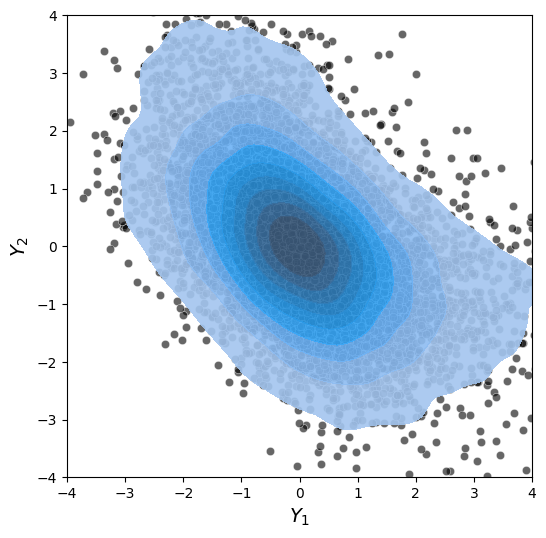

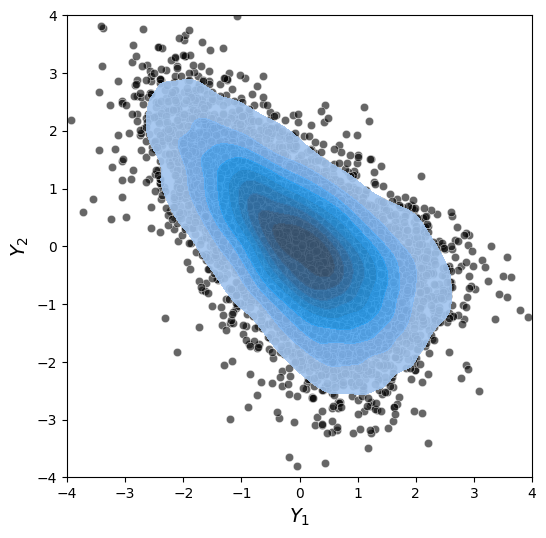

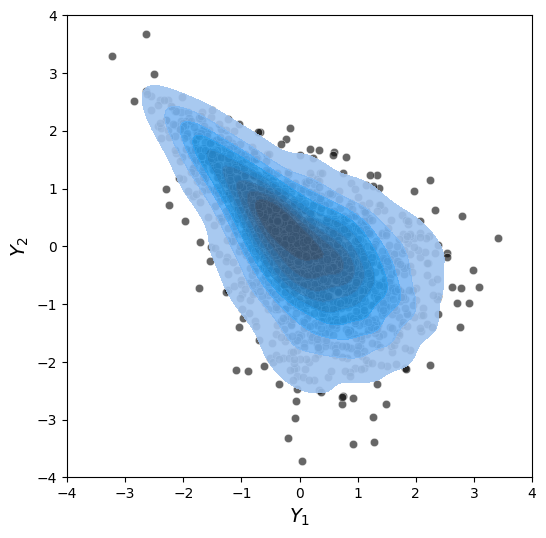

In [17]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [18]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


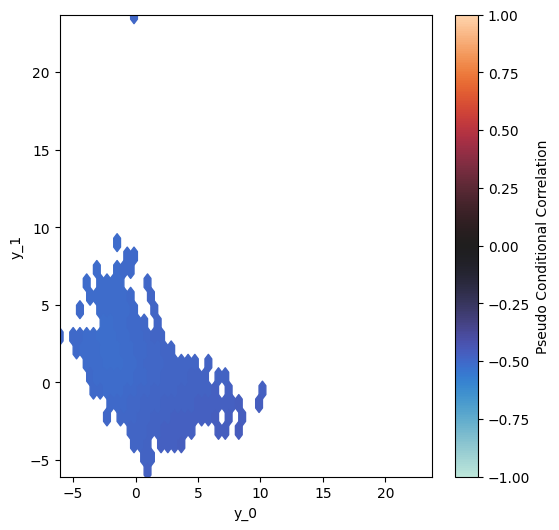

In [19]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


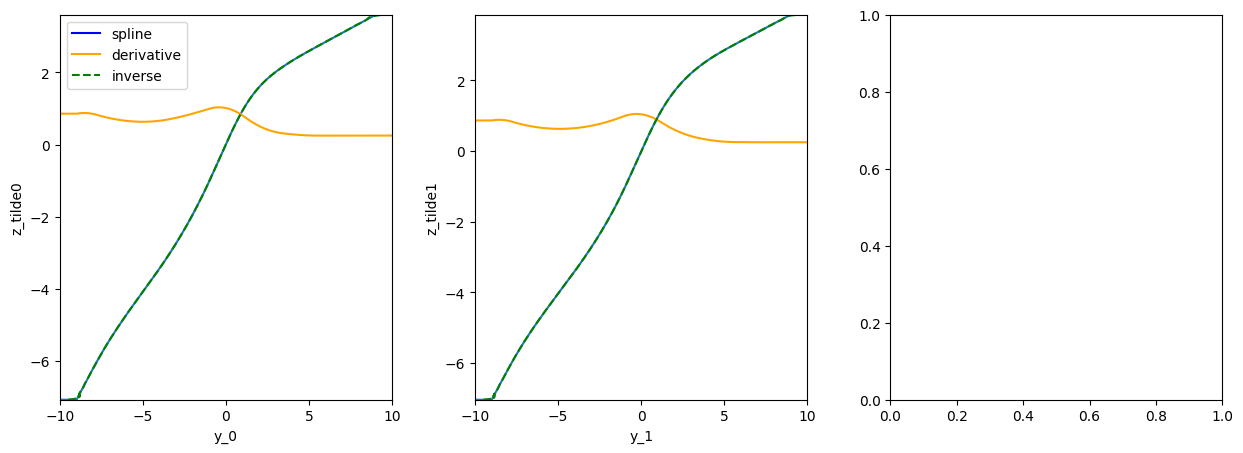

In [20]:
model.plot_splines(layer_type="transformation")

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


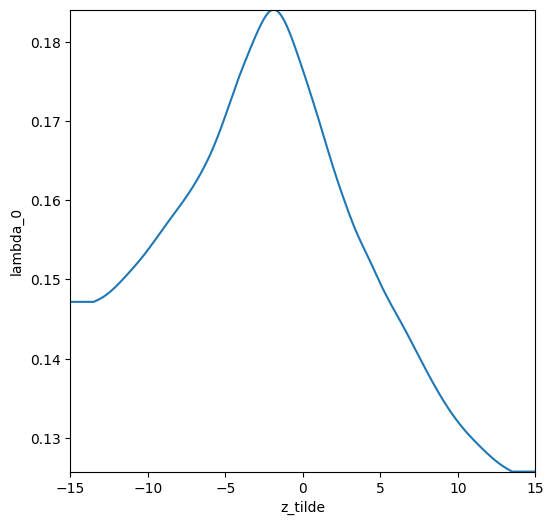

In [21]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


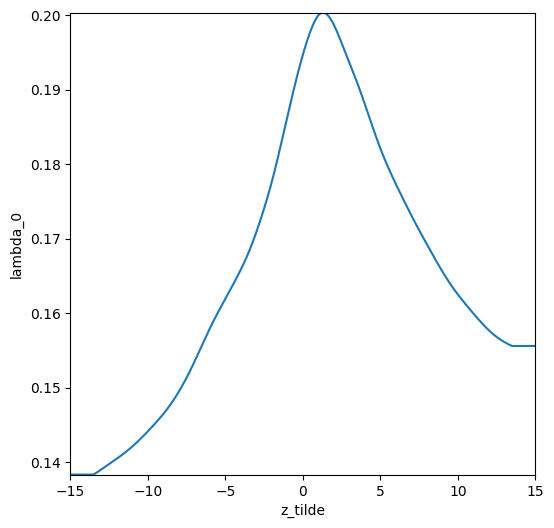

In [22]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


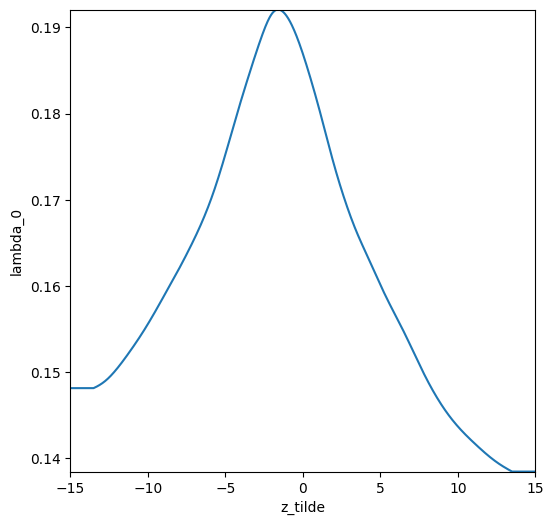

In [23]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)